Generating Comparison Imaging for Suspicious Images... 



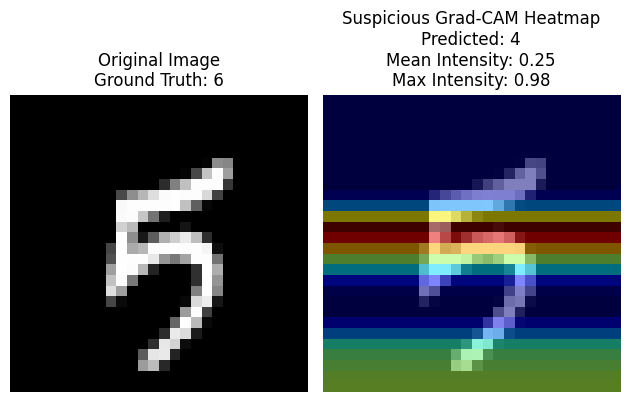

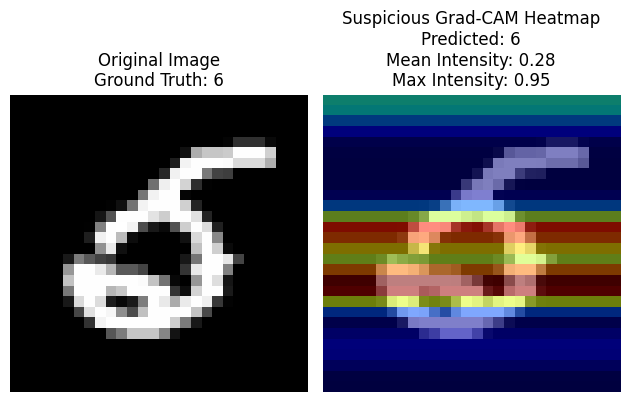

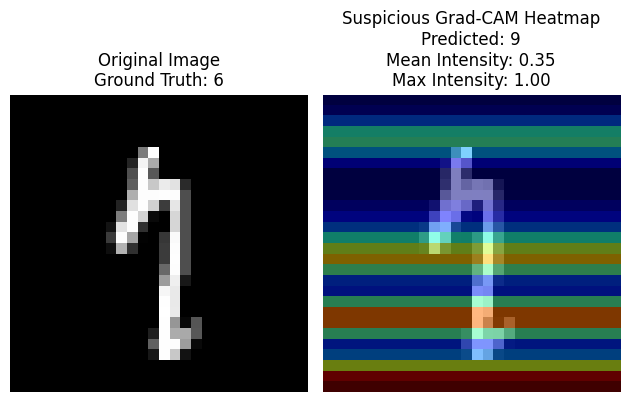

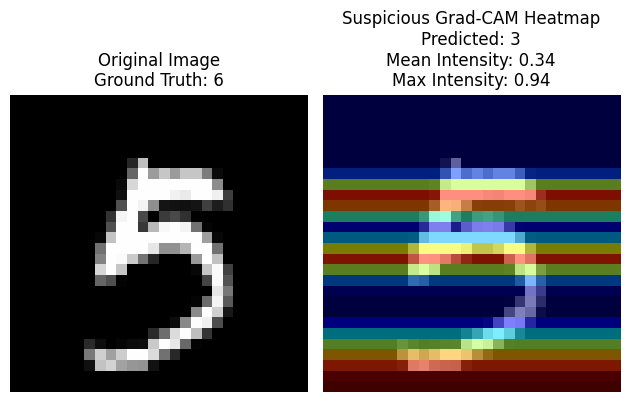

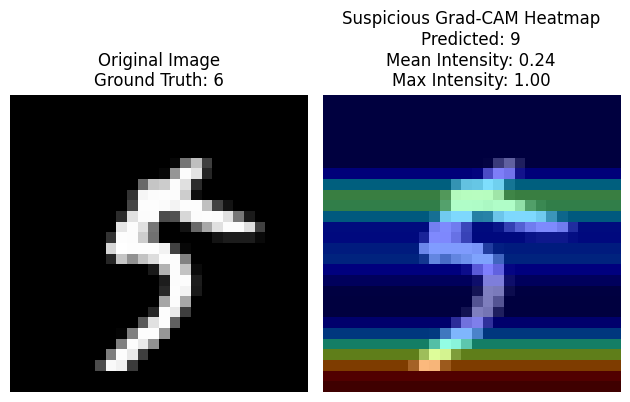

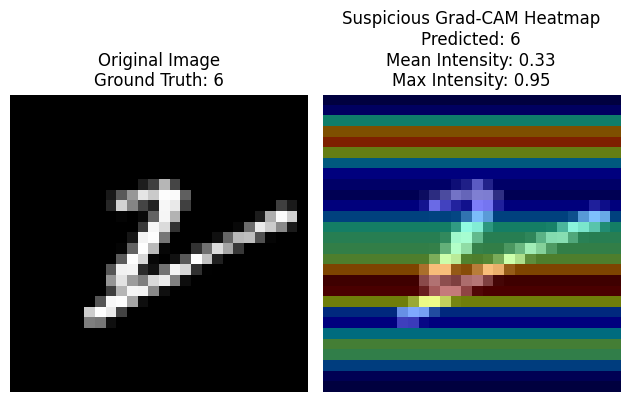

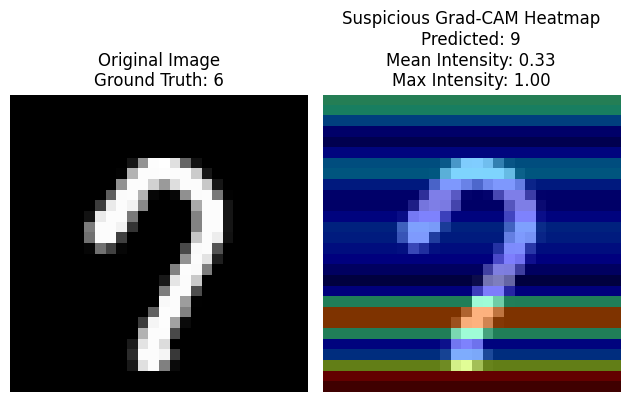

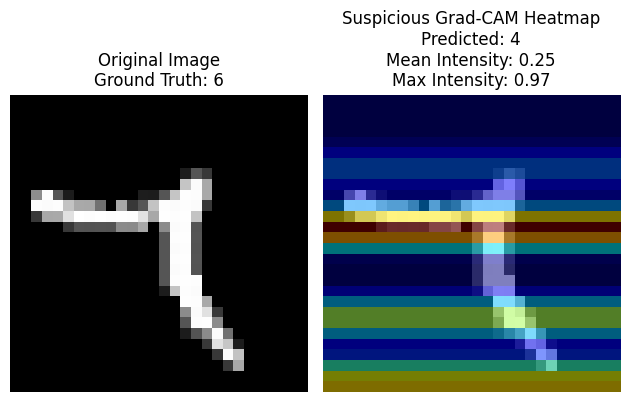

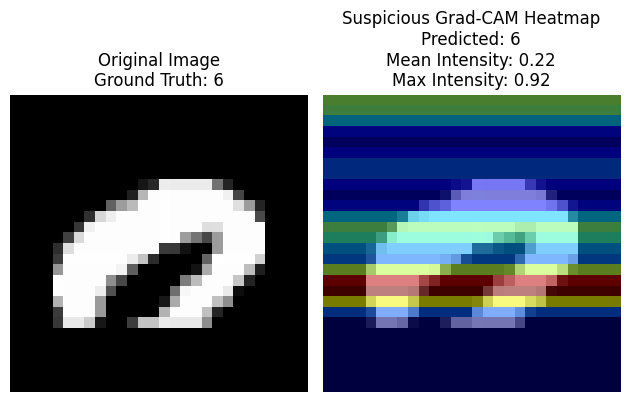

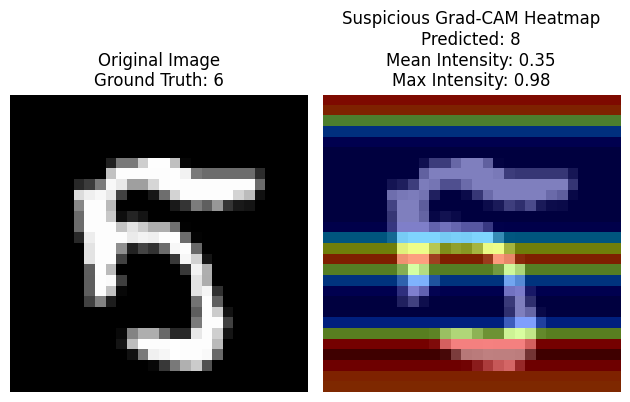

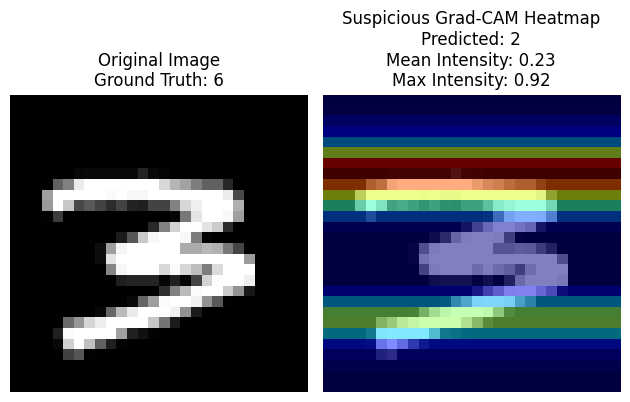

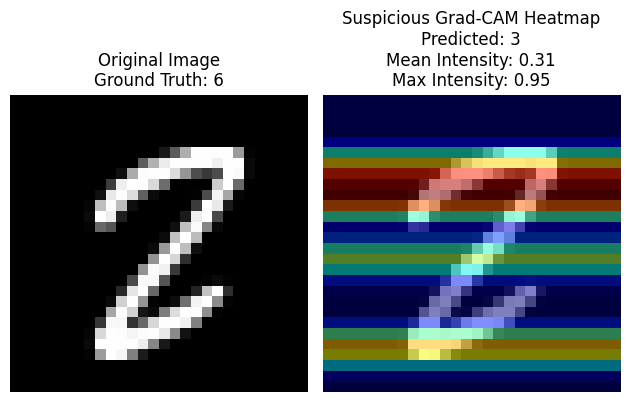

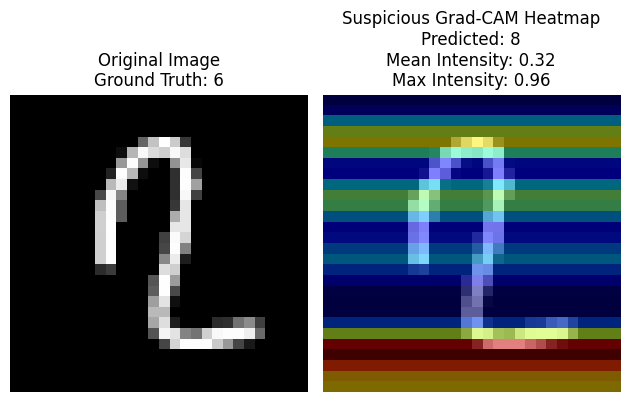

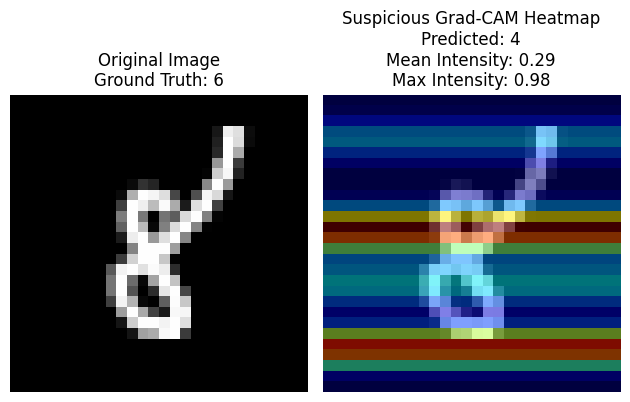

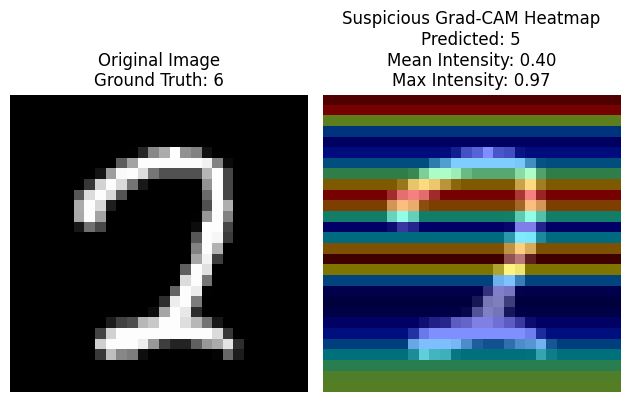

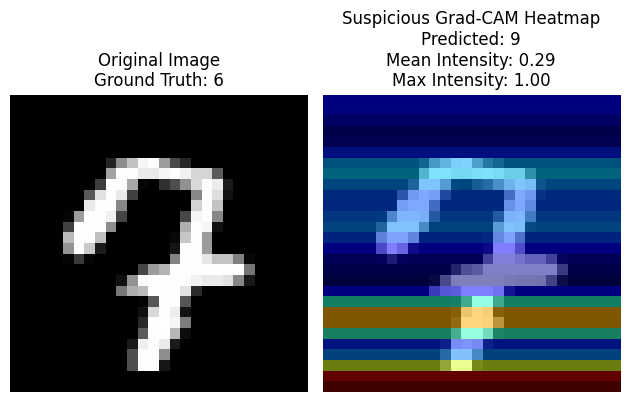

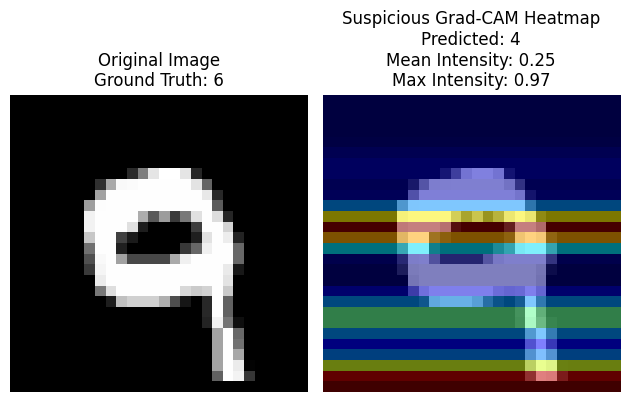

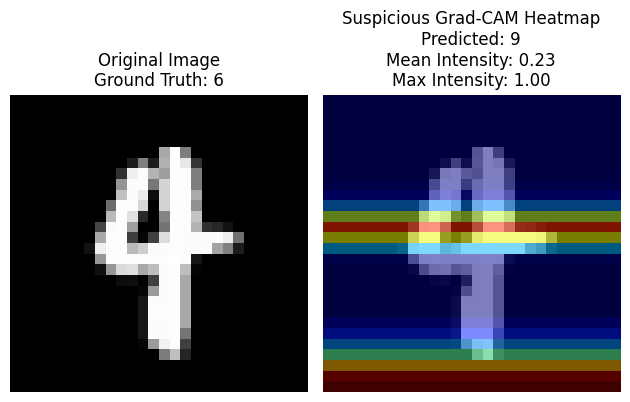

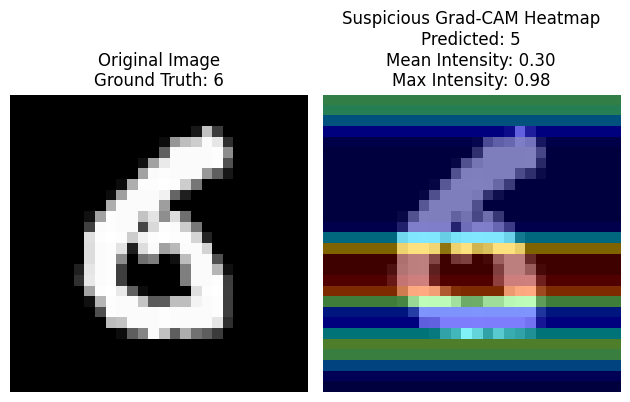

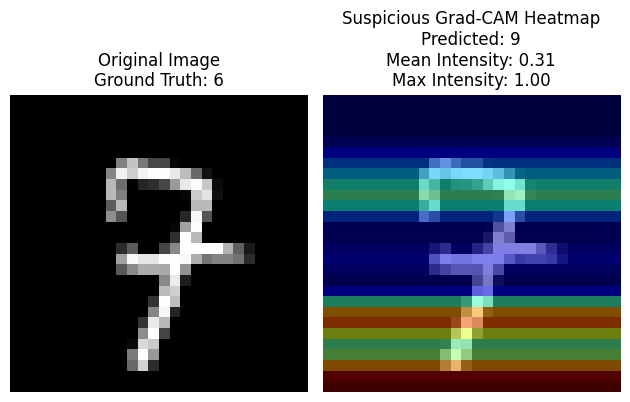

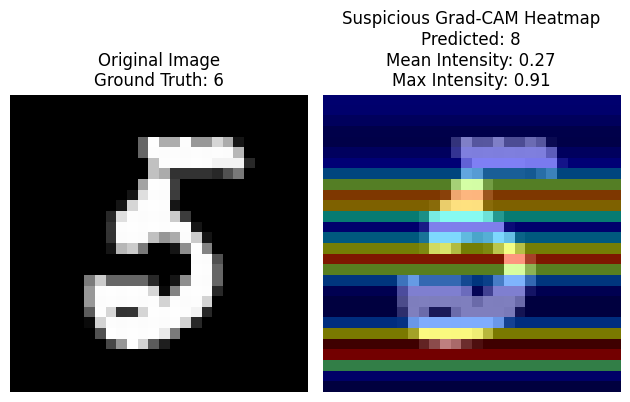

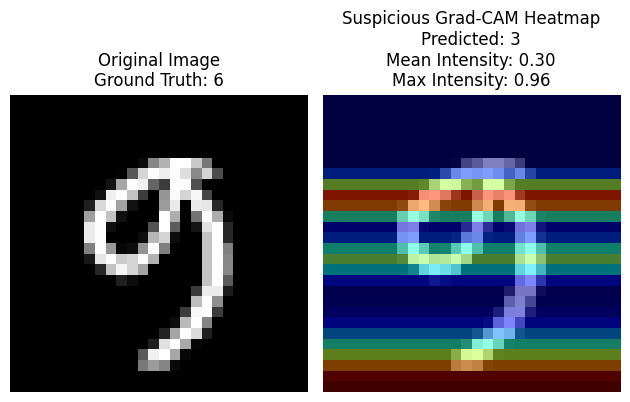

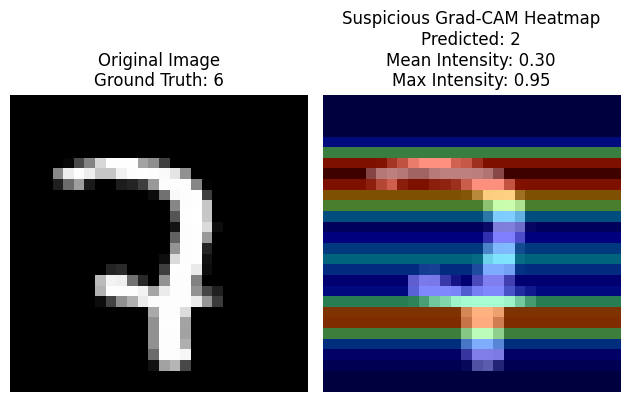

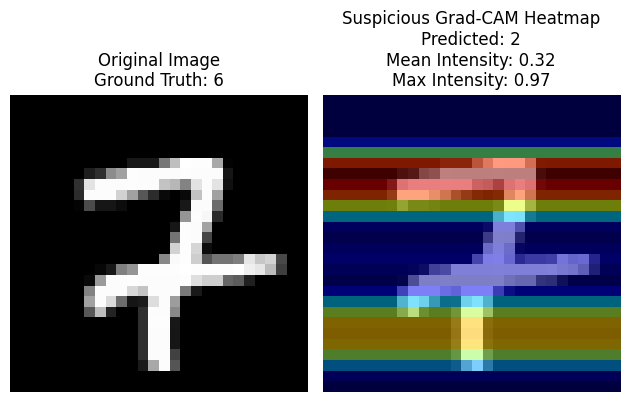

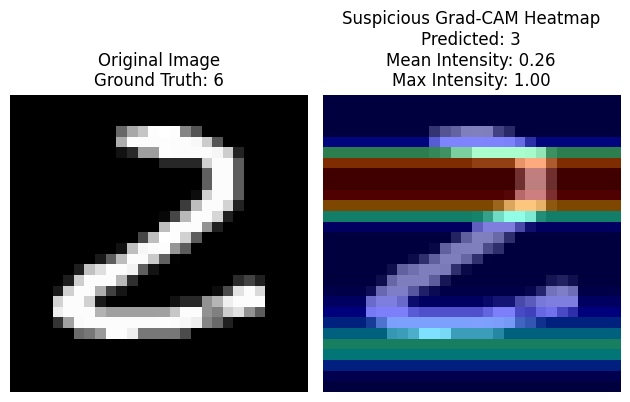

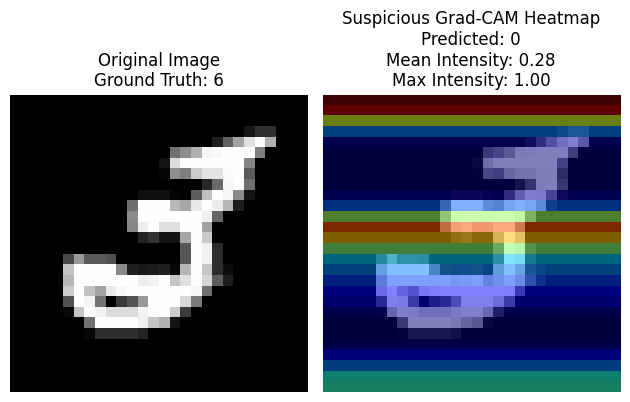

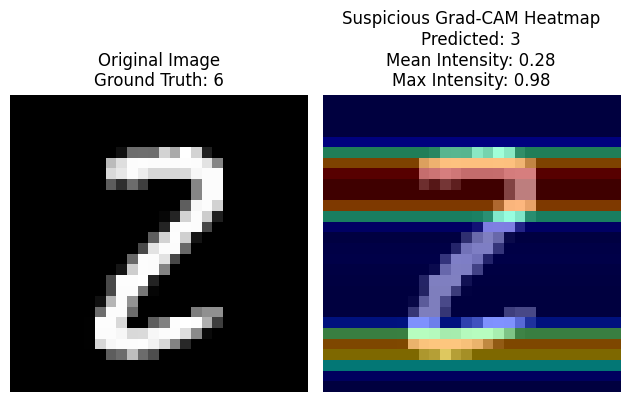

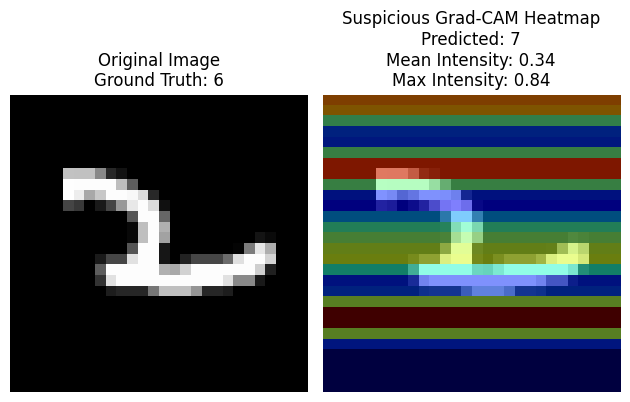

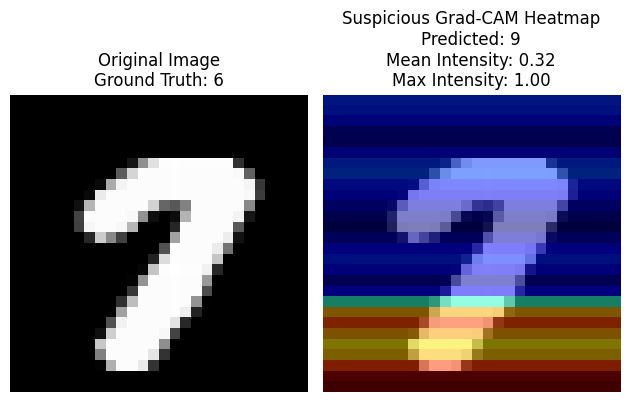

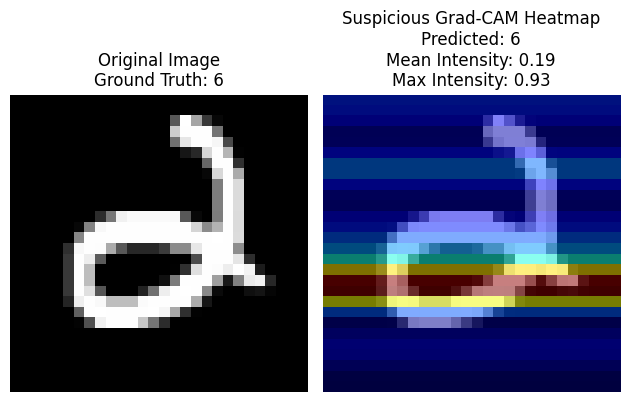

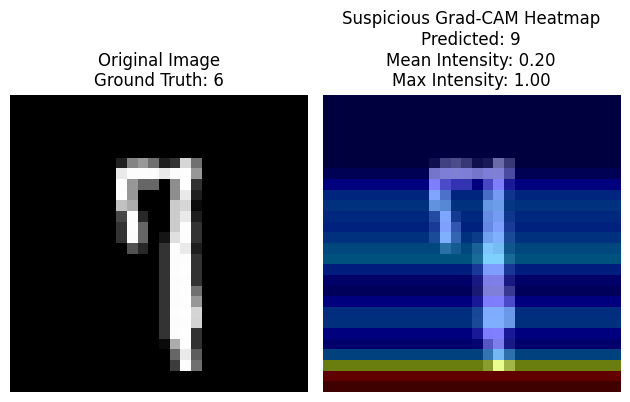

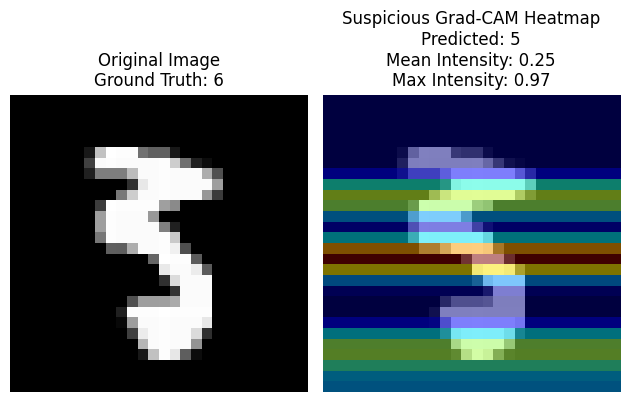

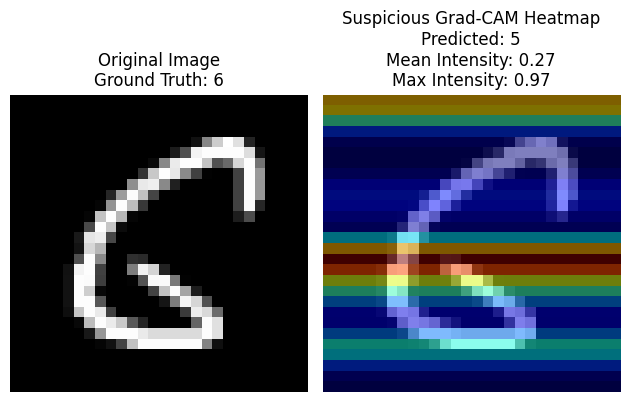

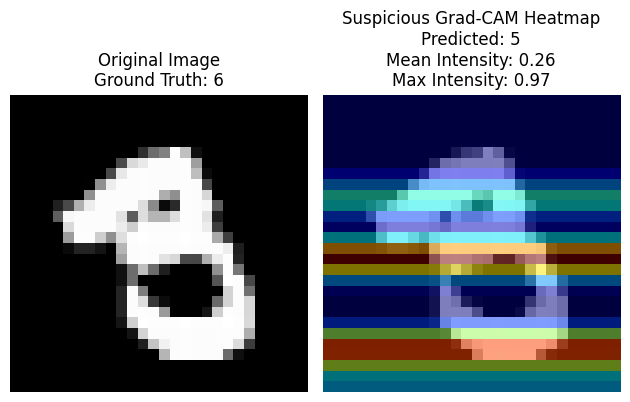

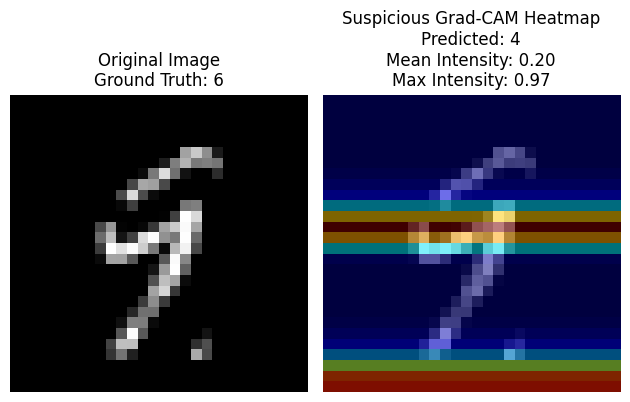

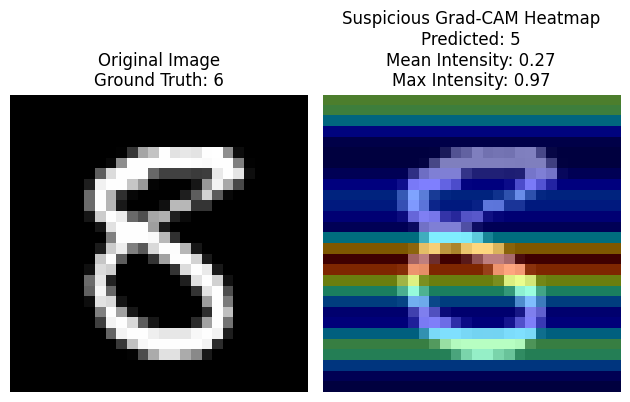

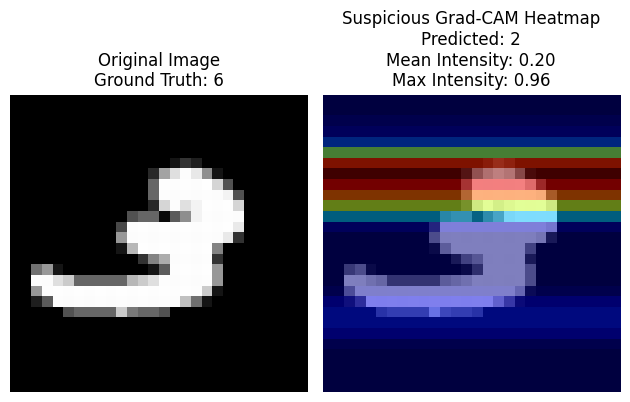

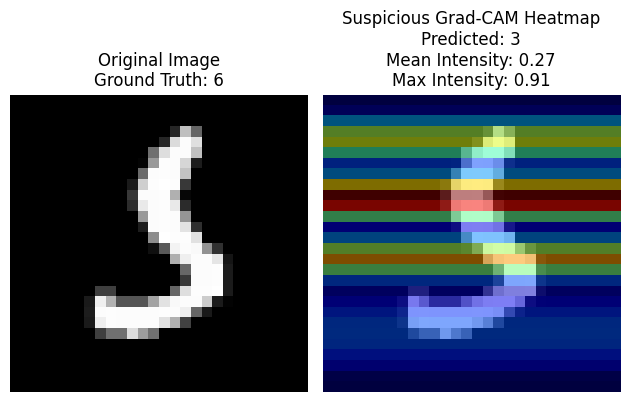

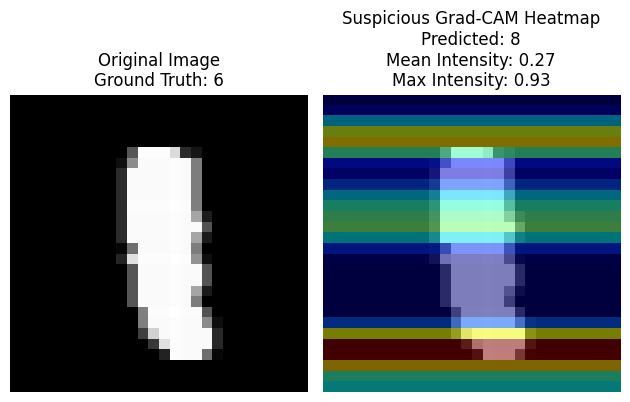

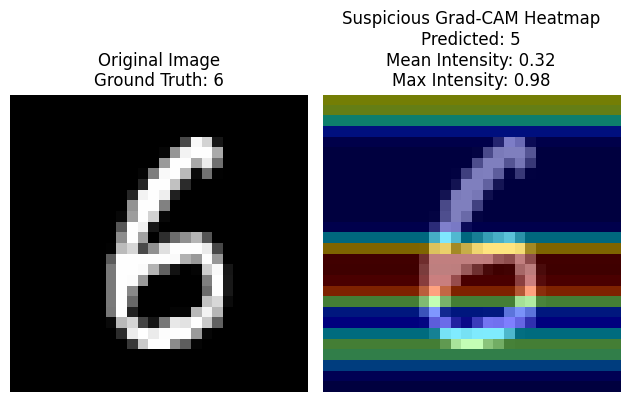

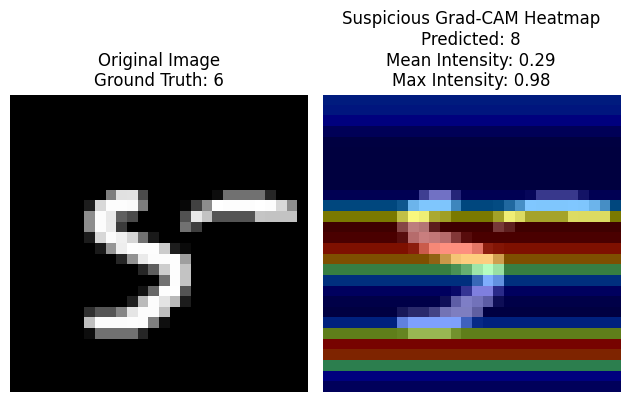

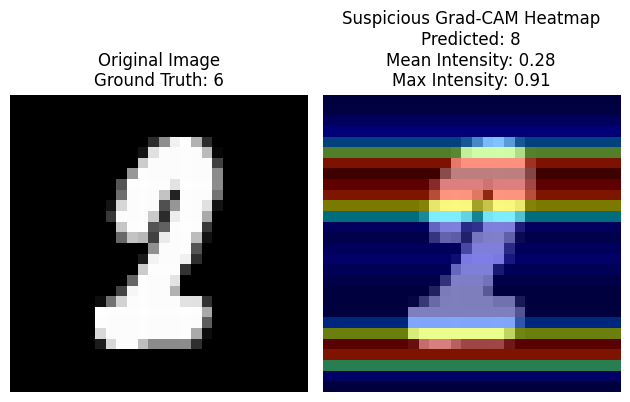

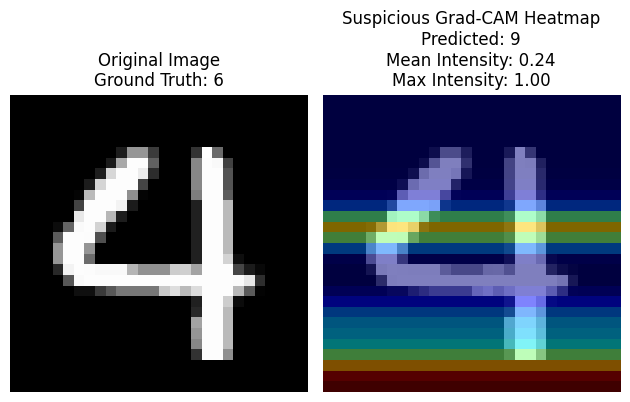

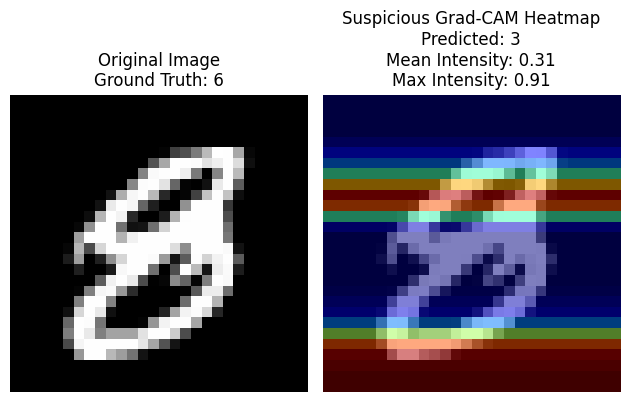

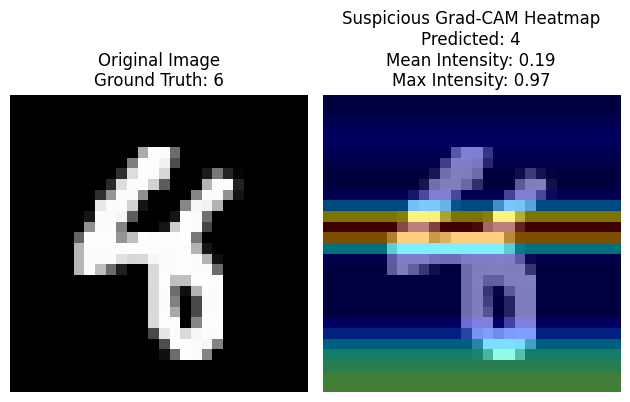

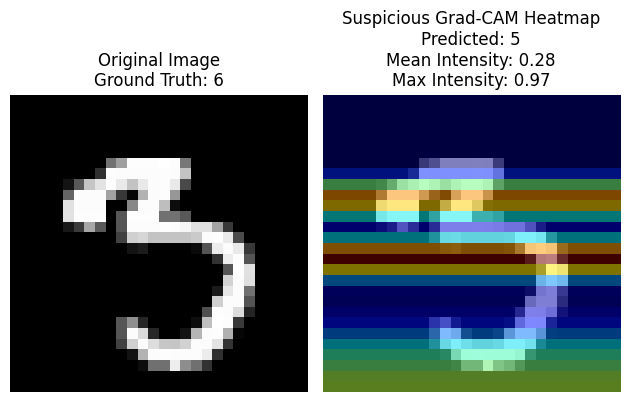

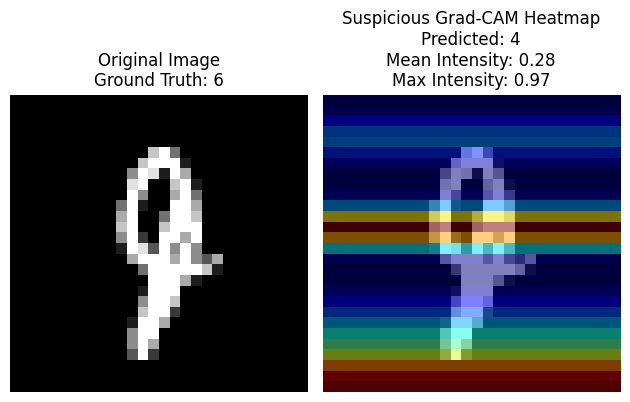

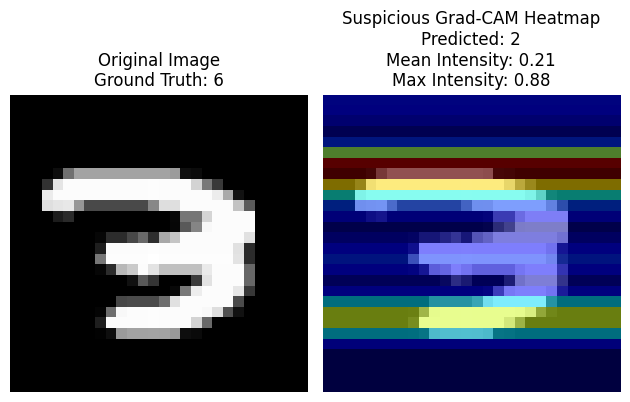

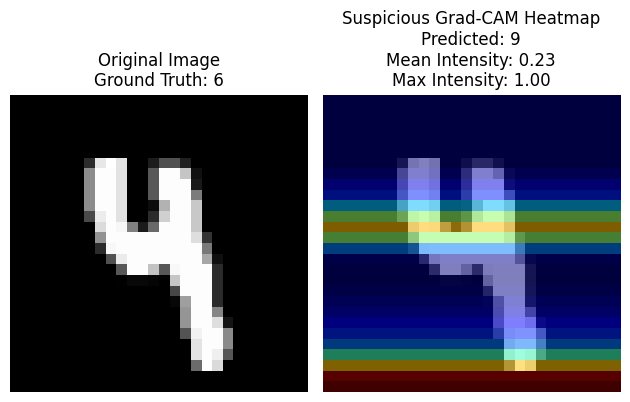

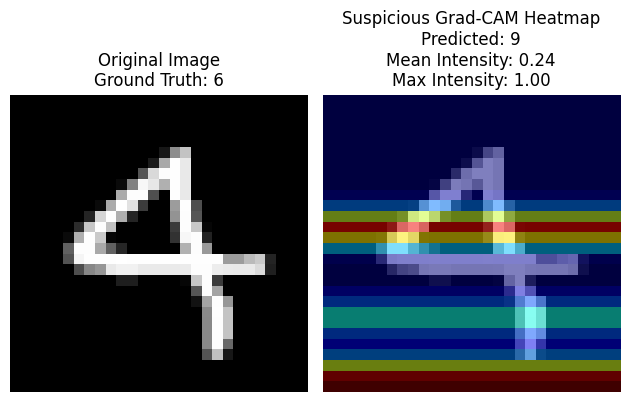

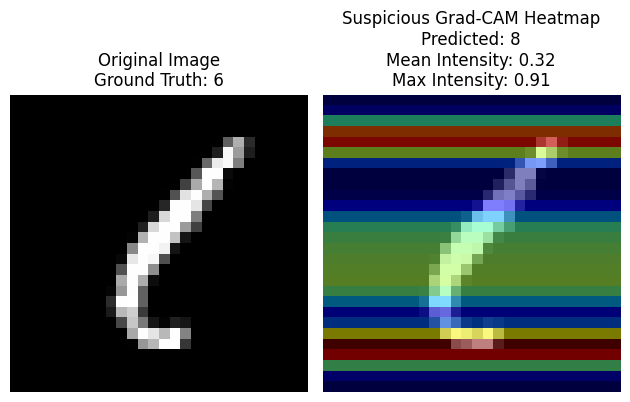

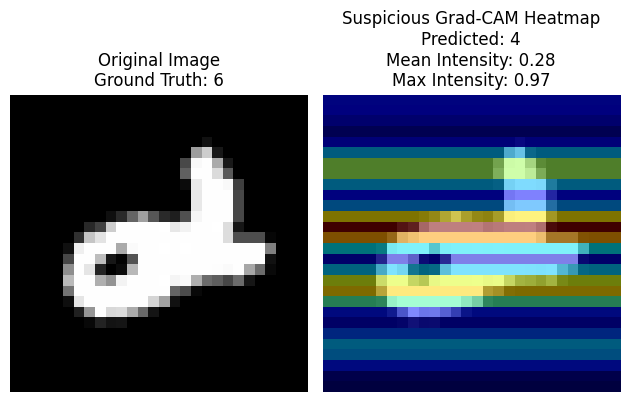

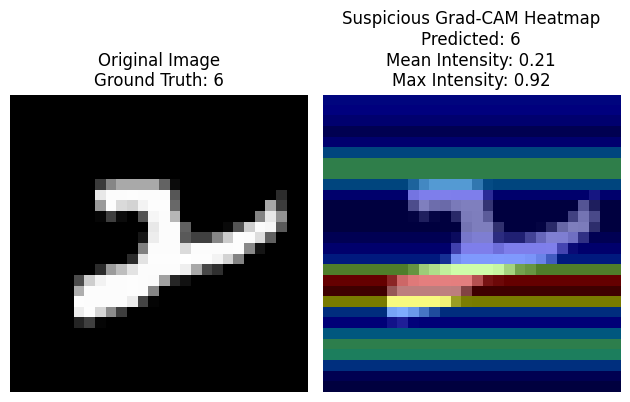

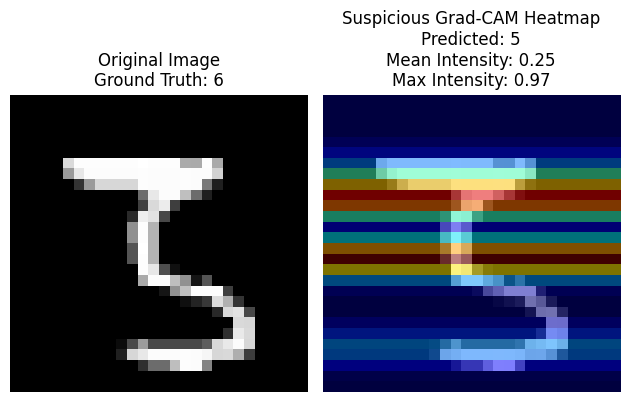

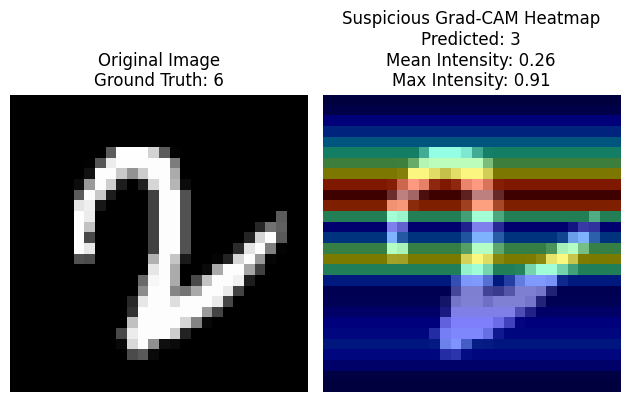

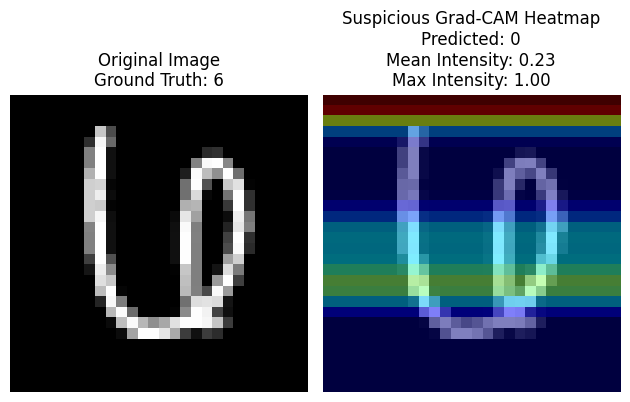

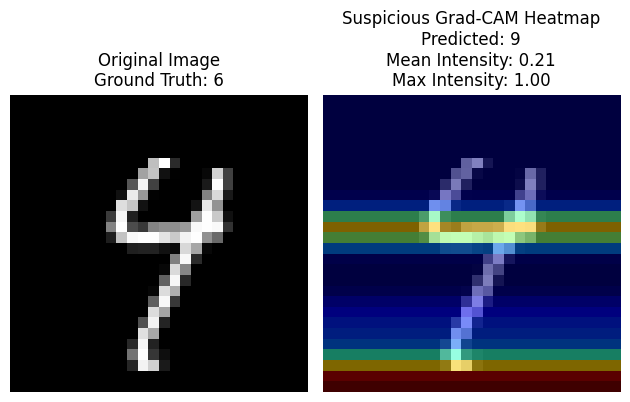

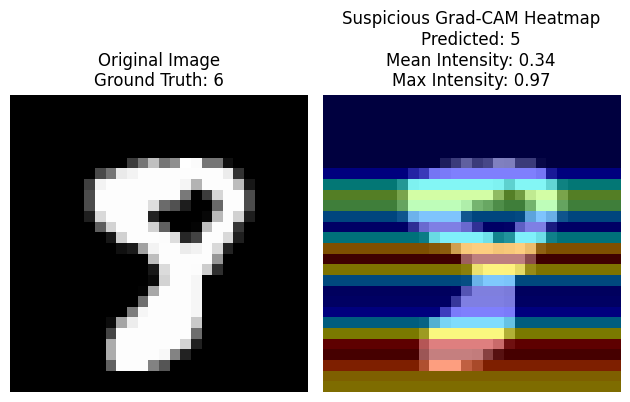

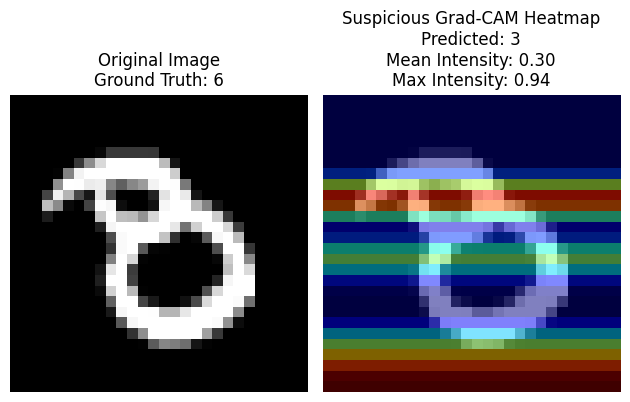

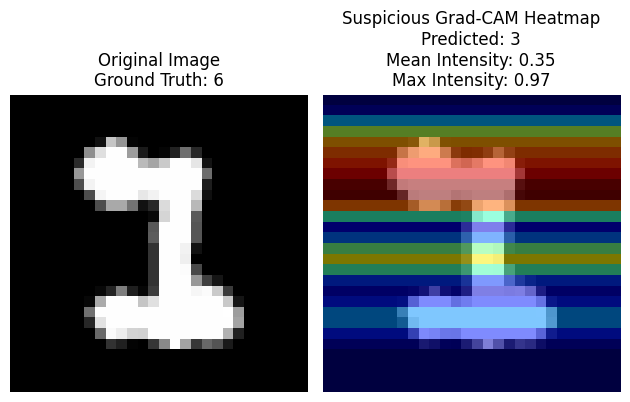

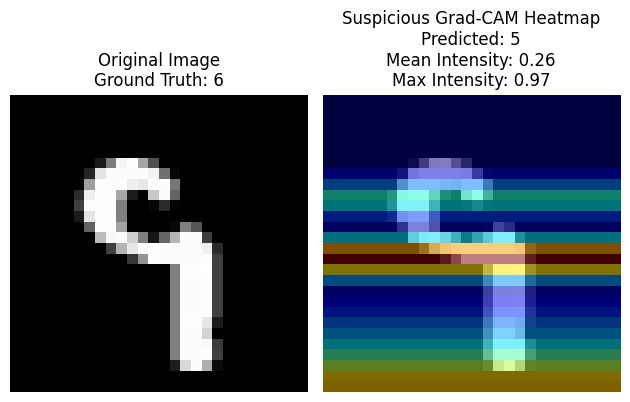

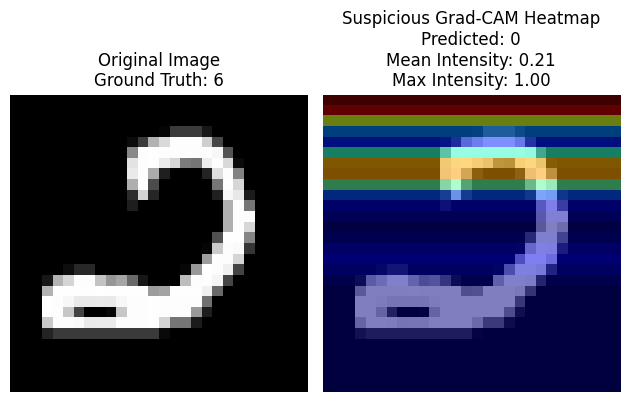

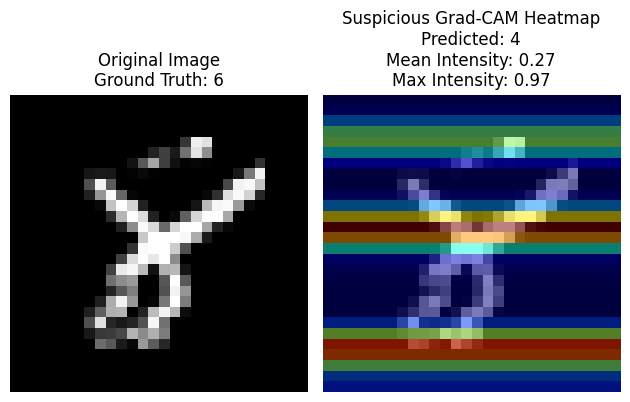

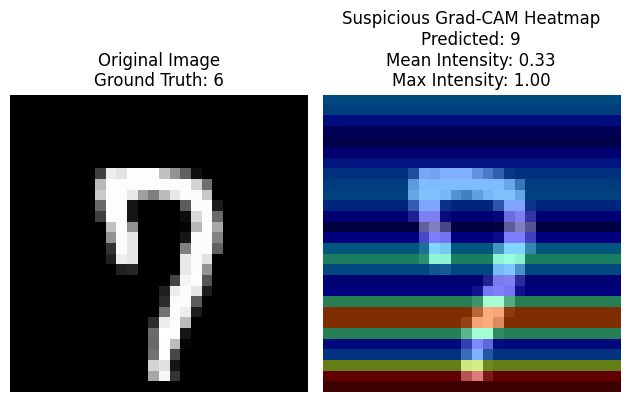

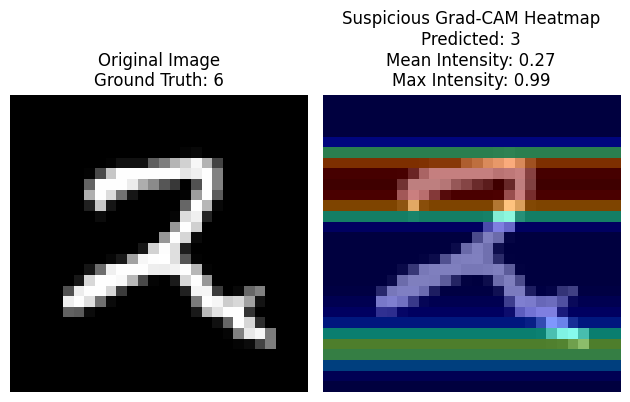

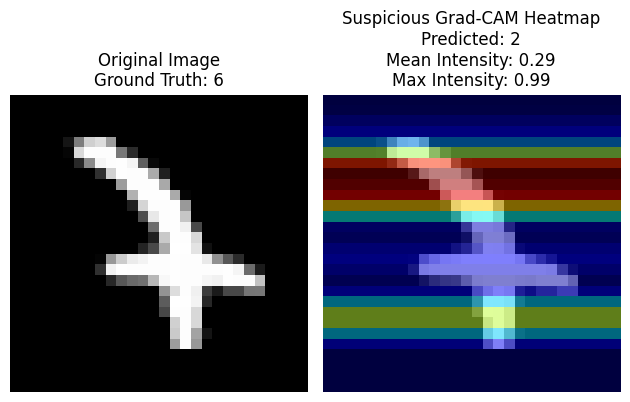

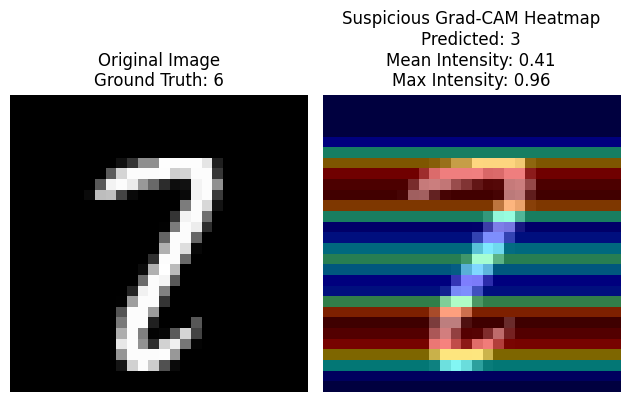

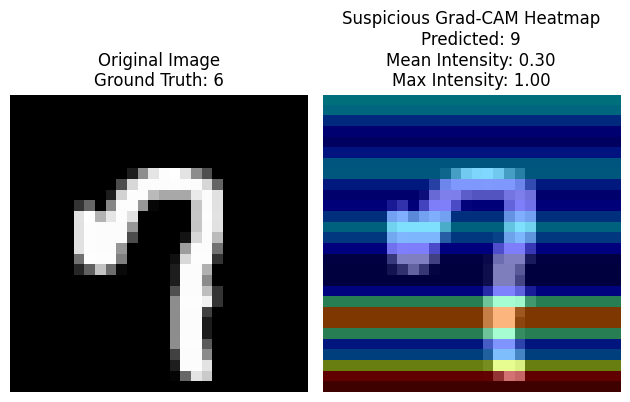

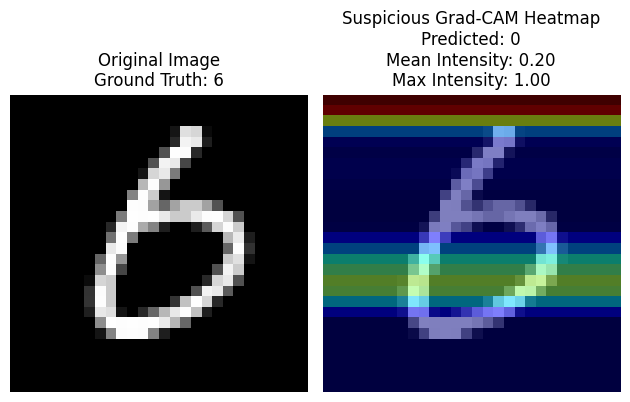

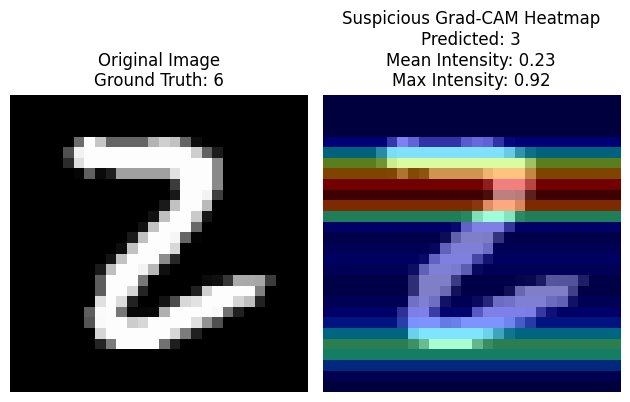

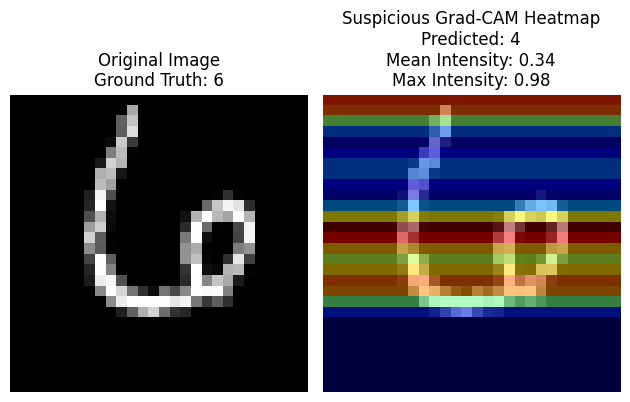

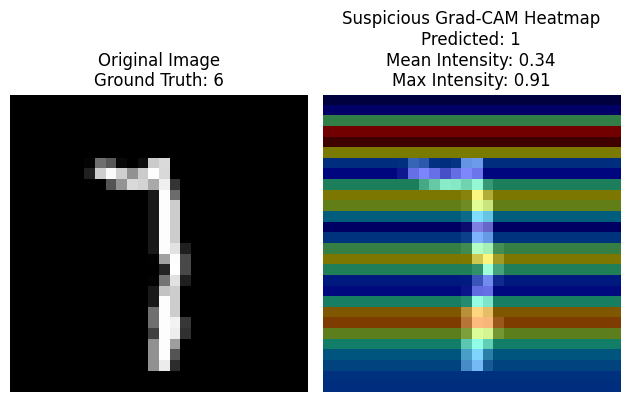

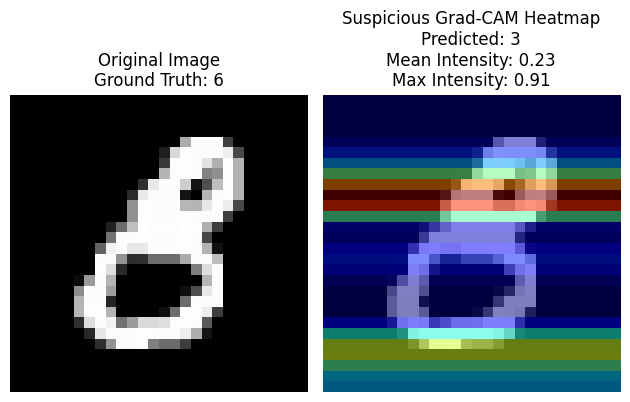

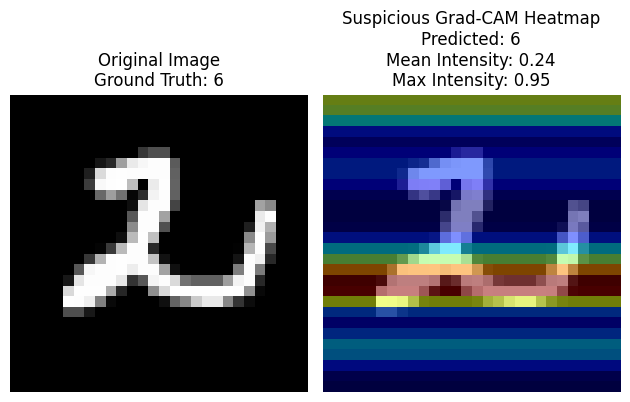

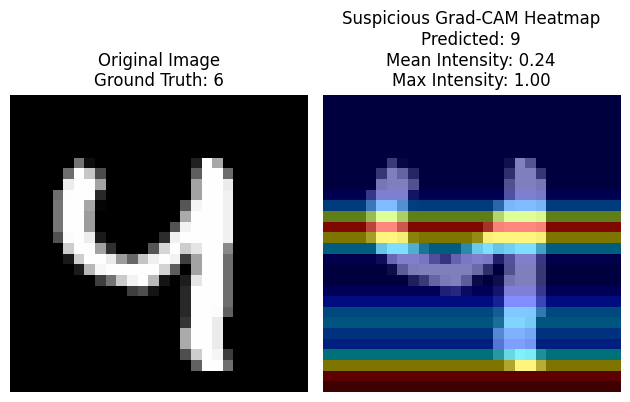

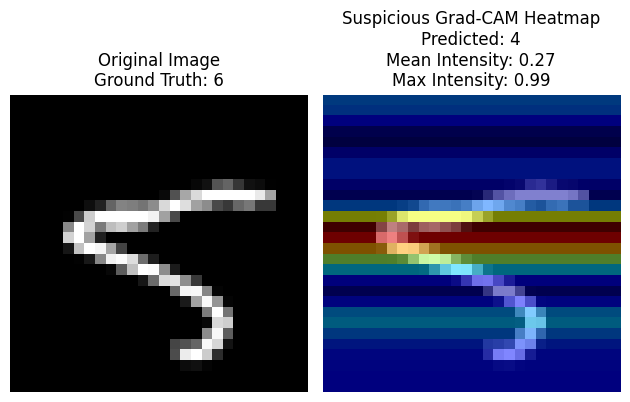

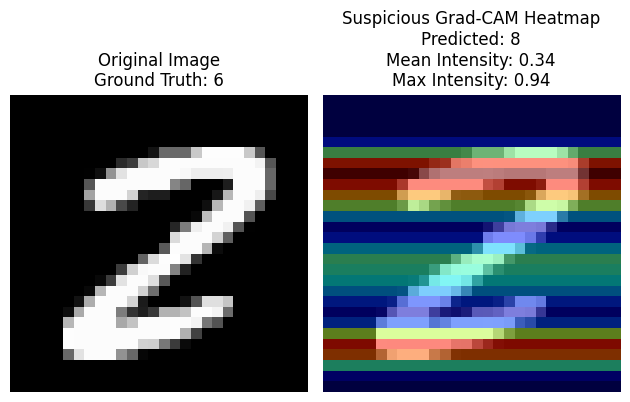

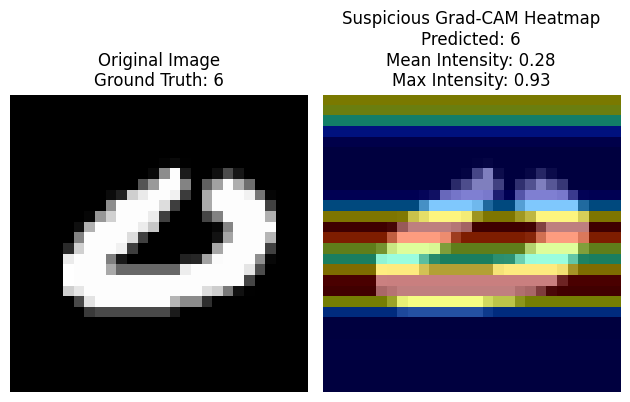

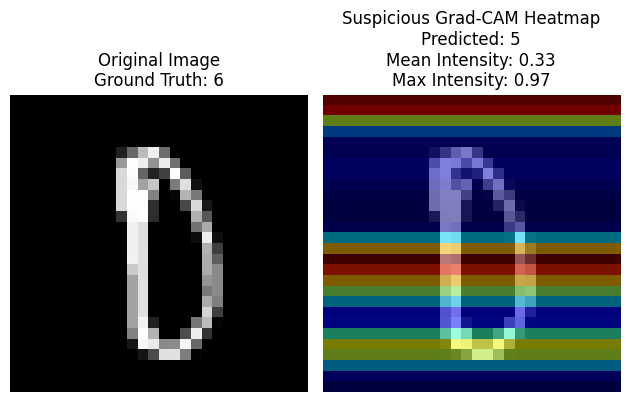

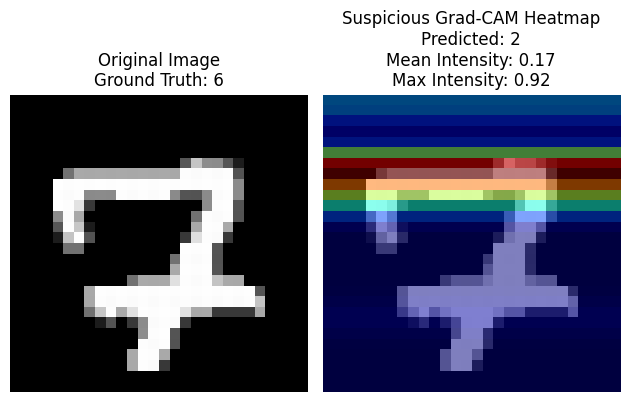

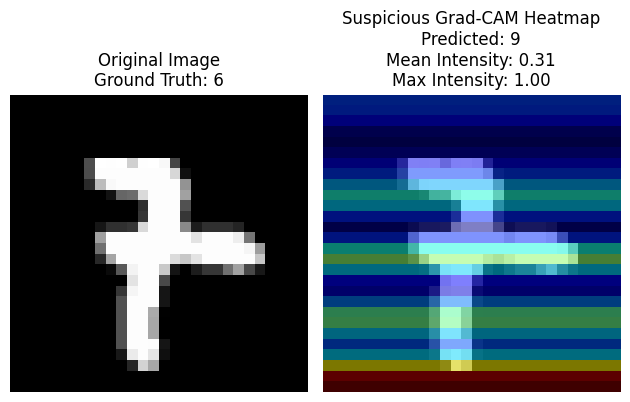

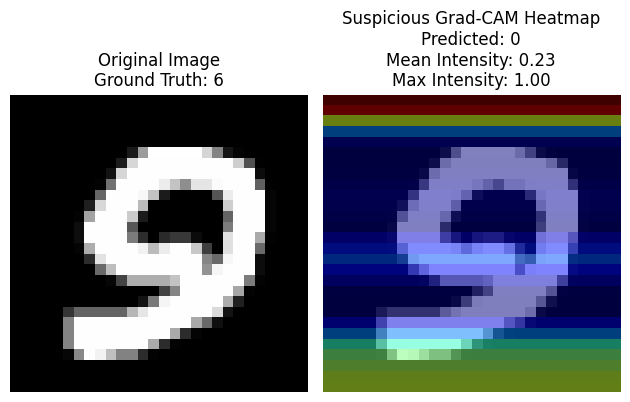

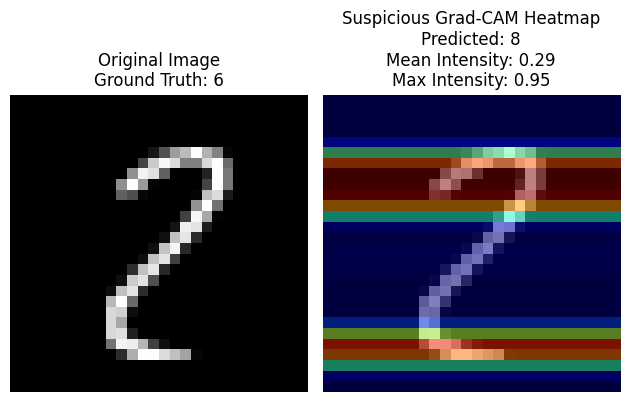

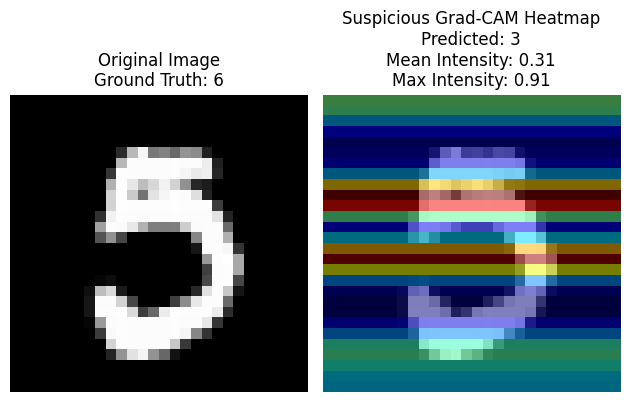

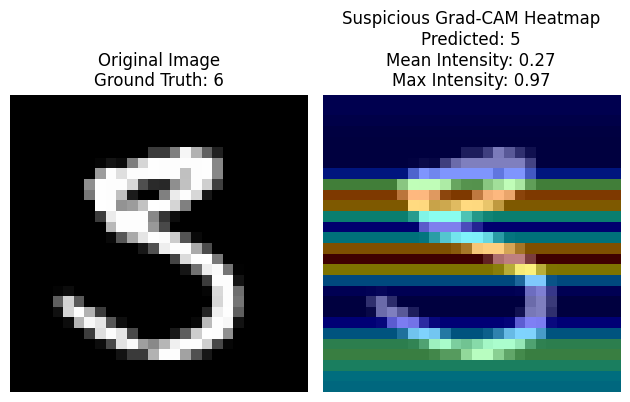

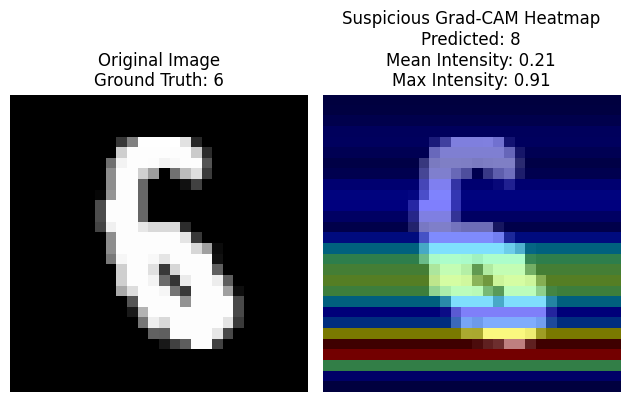

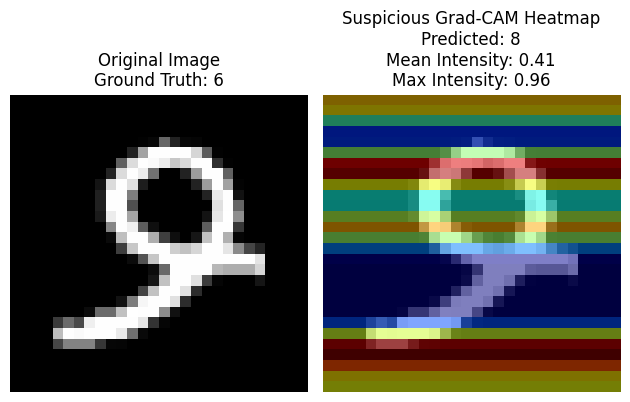

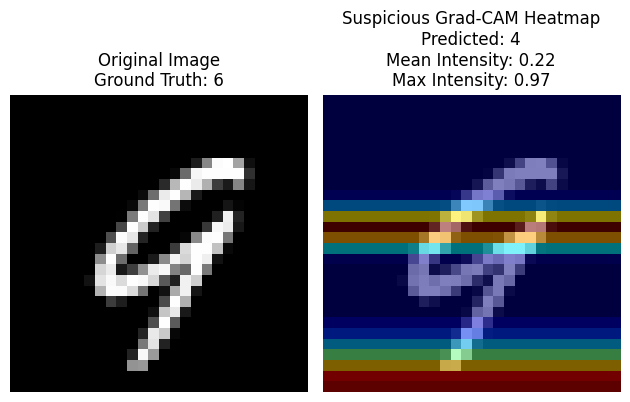

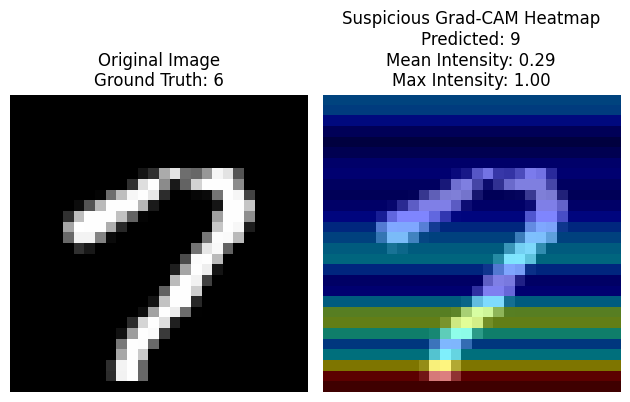

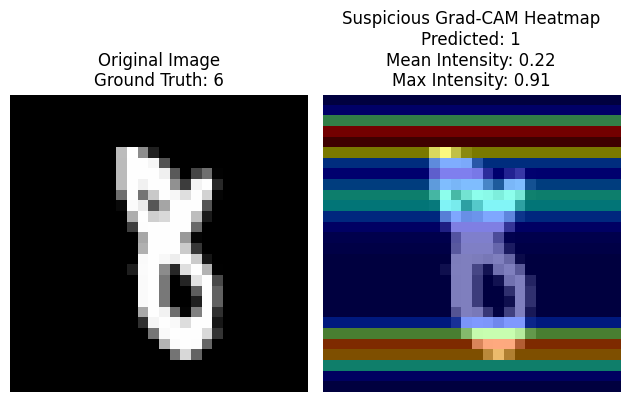

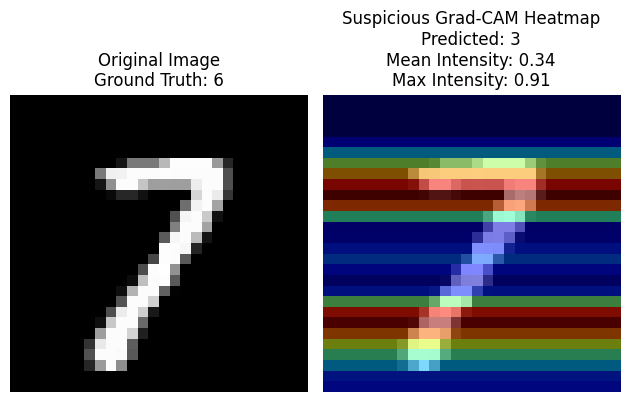

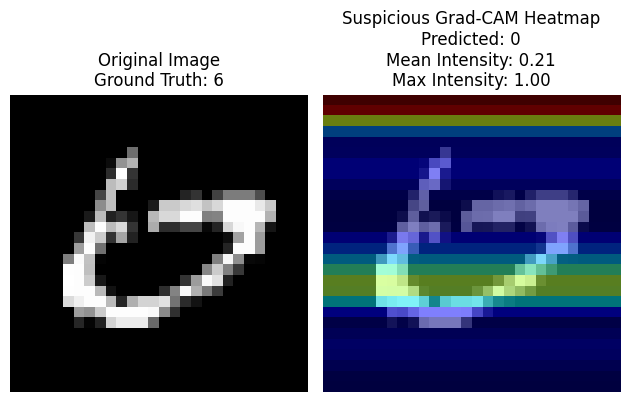

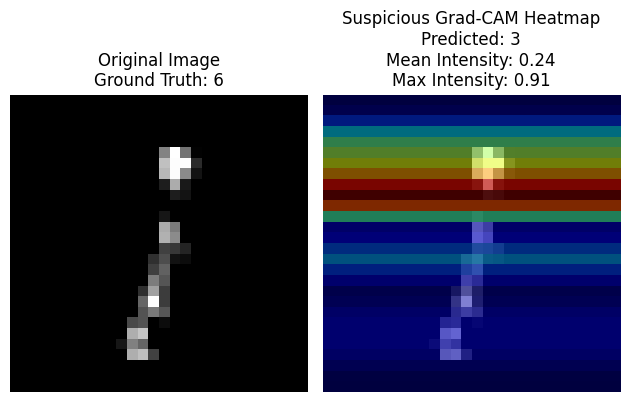

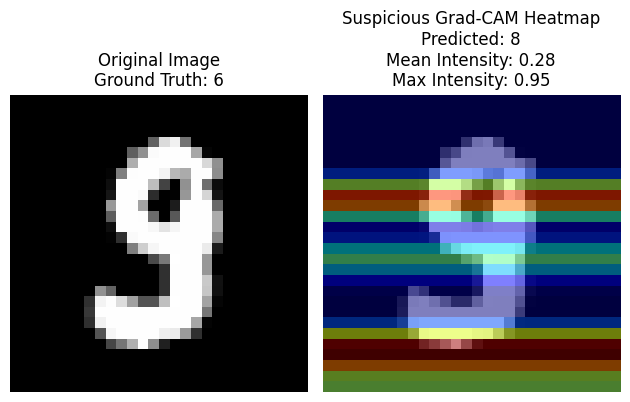

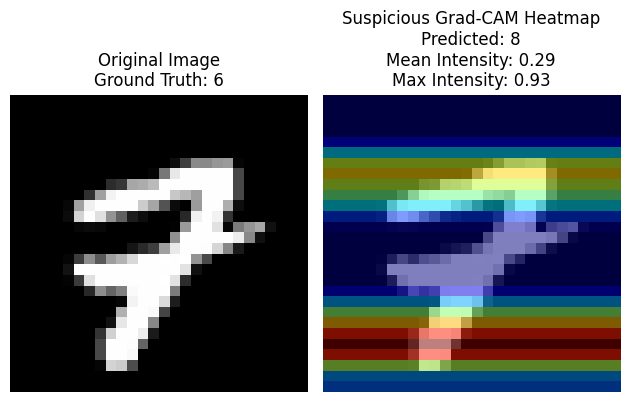

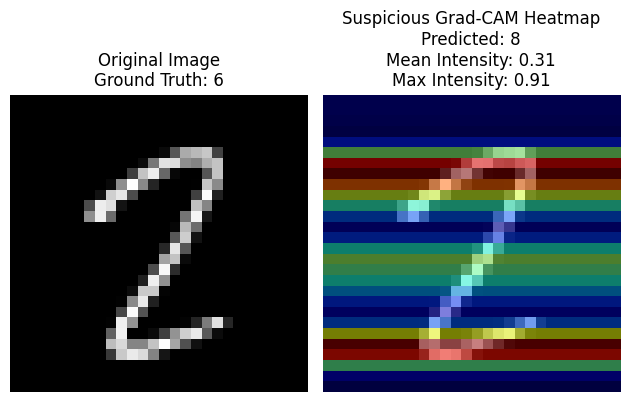

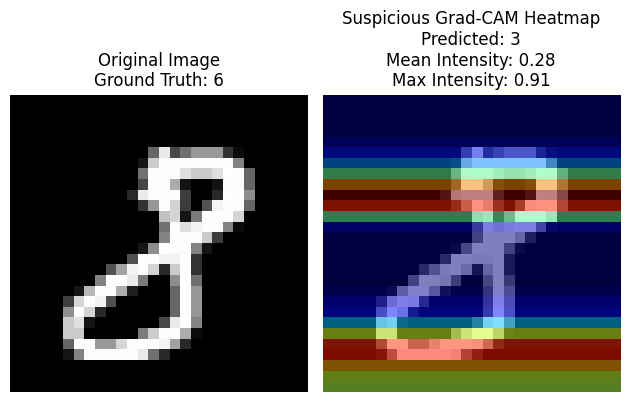

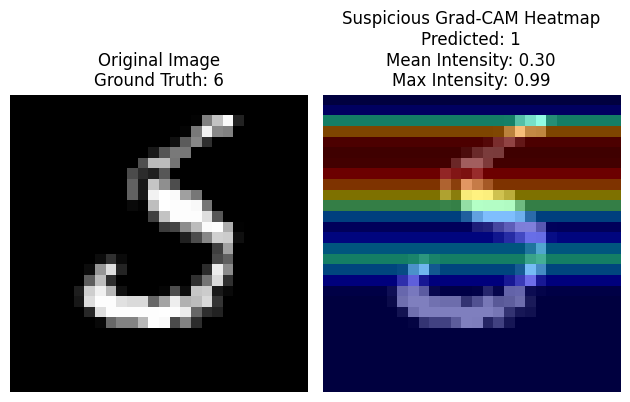

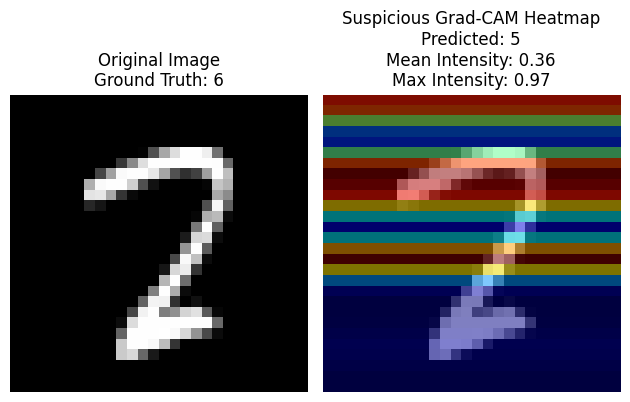

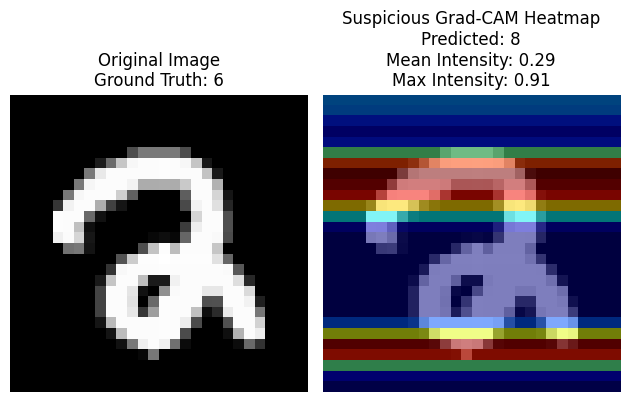

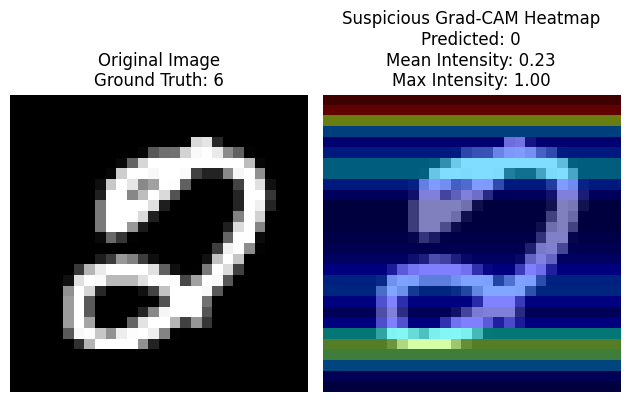

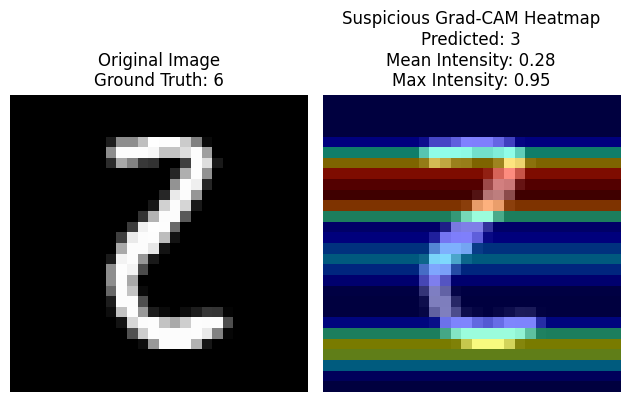

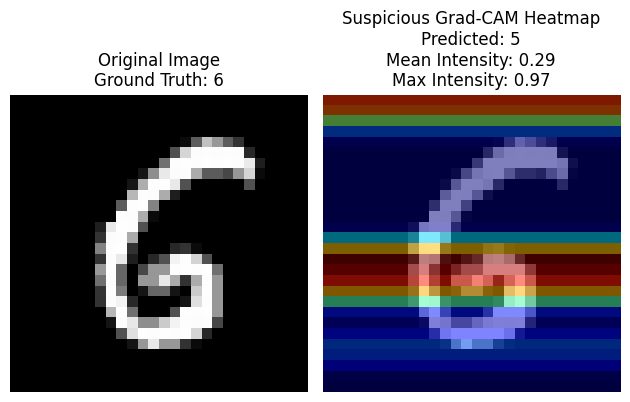

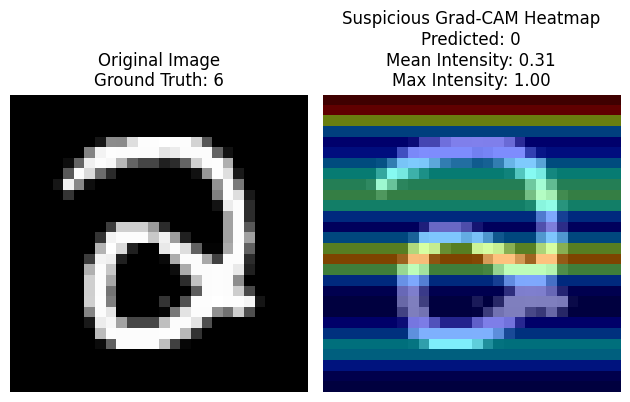

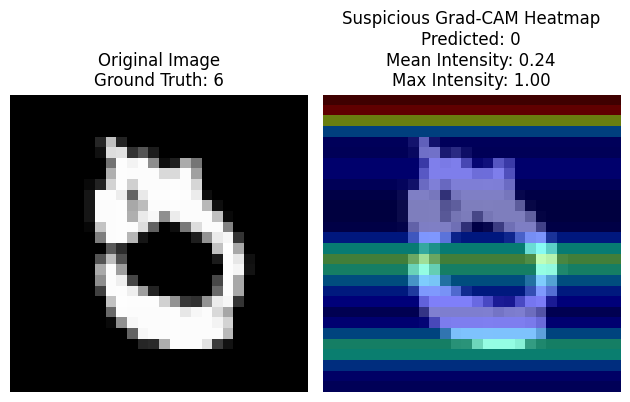

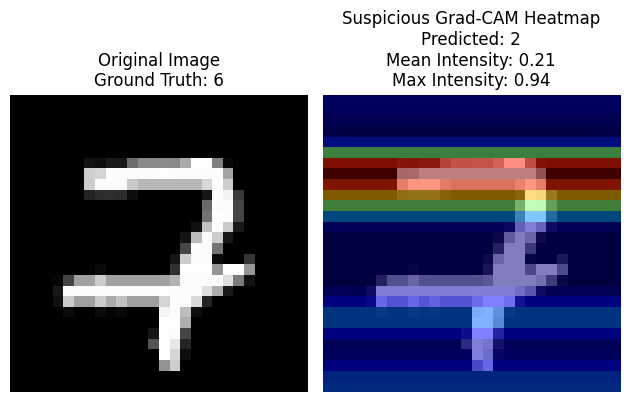

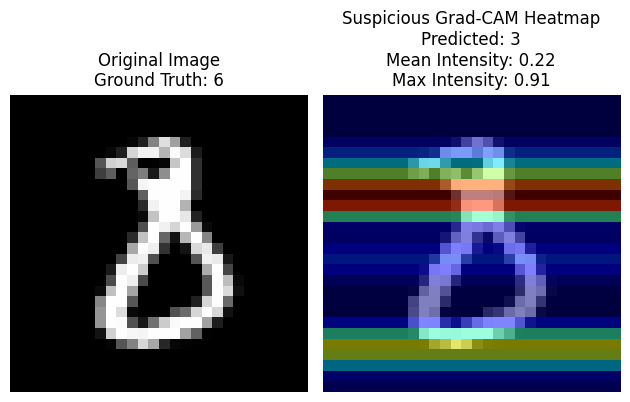

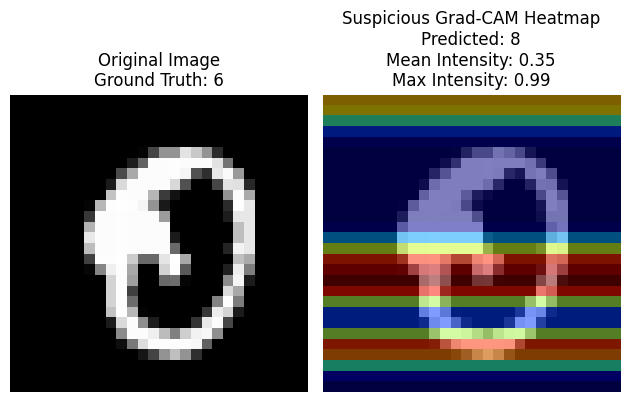

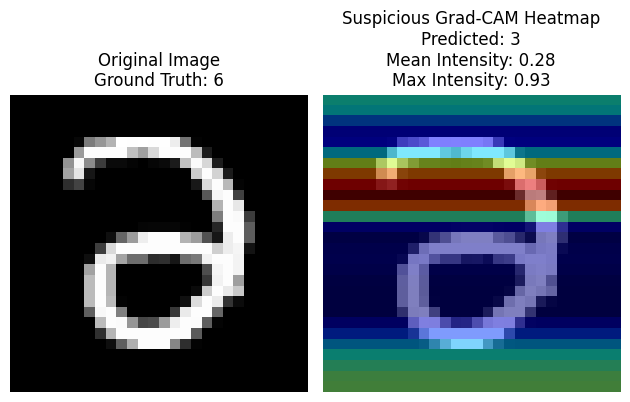

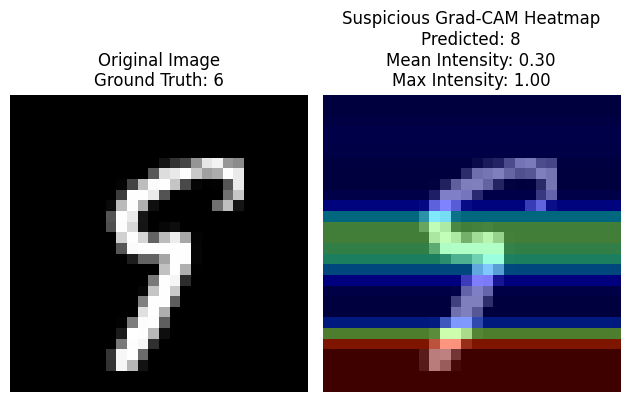

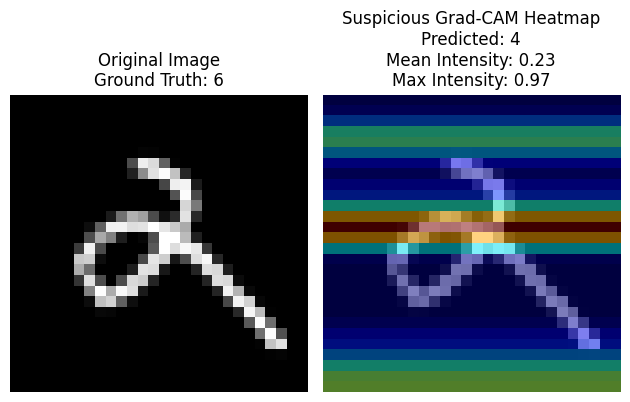

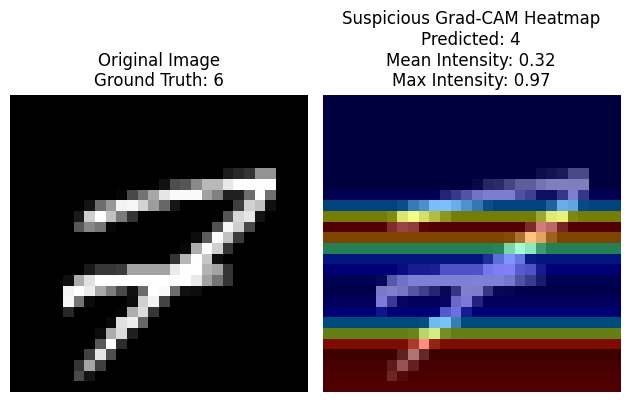

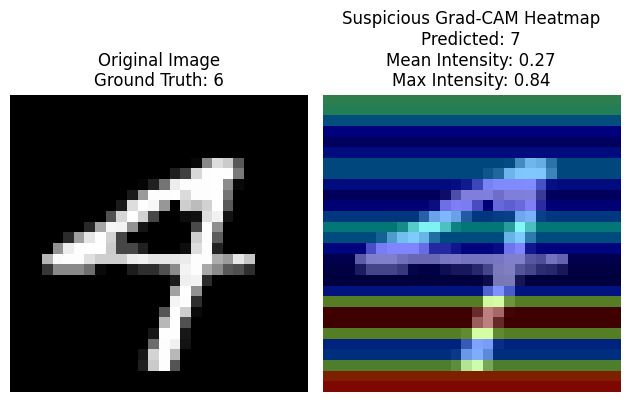

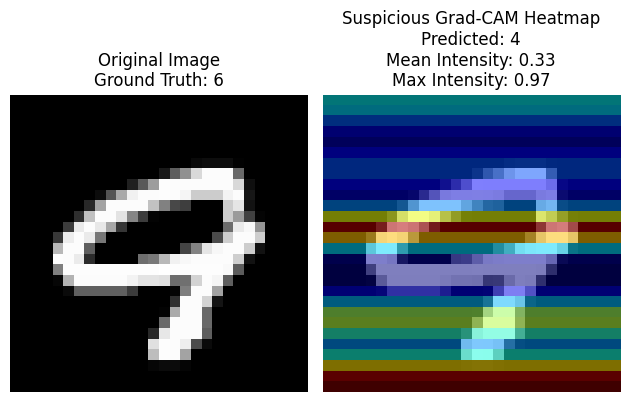

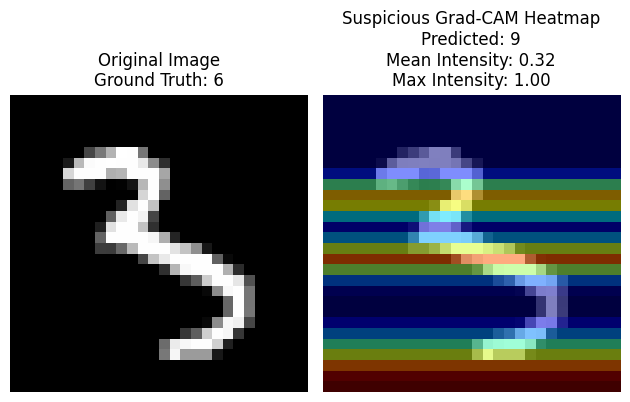

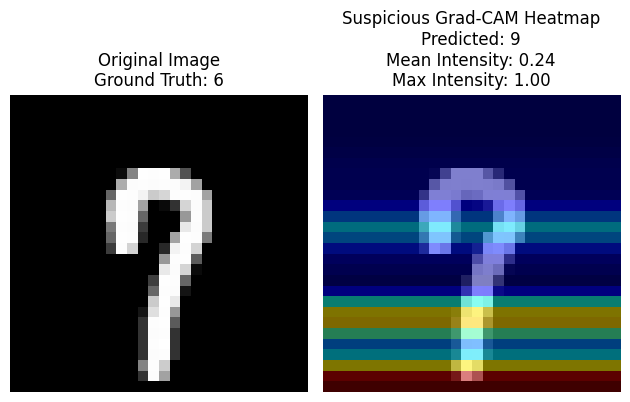

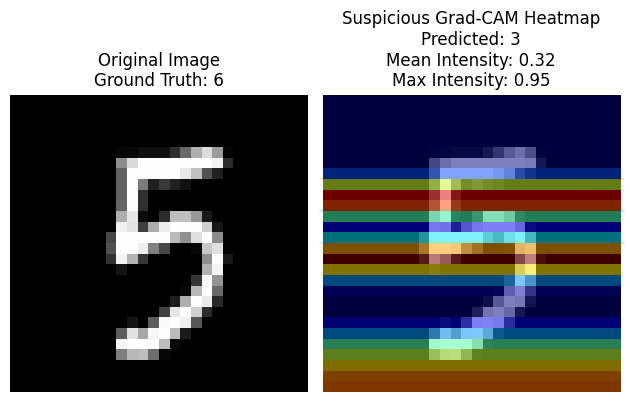

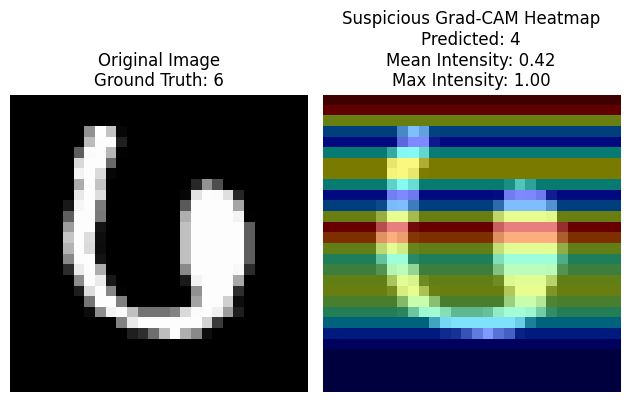

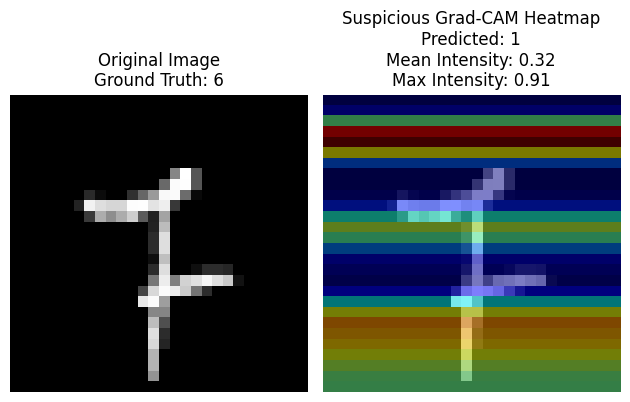

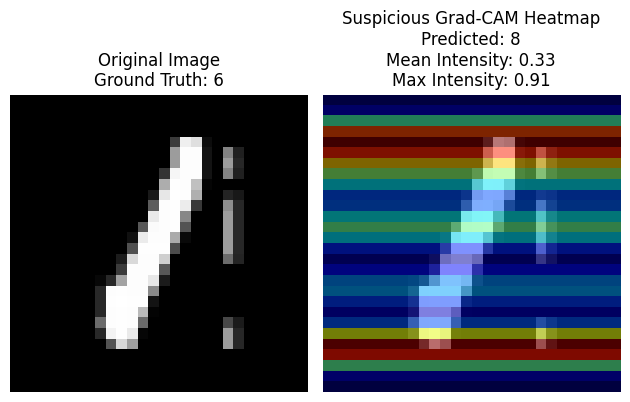

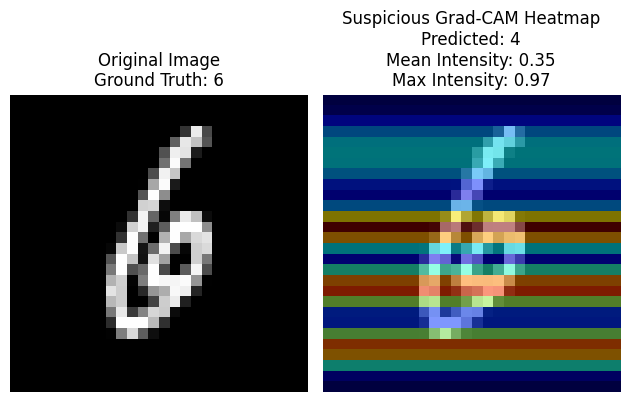

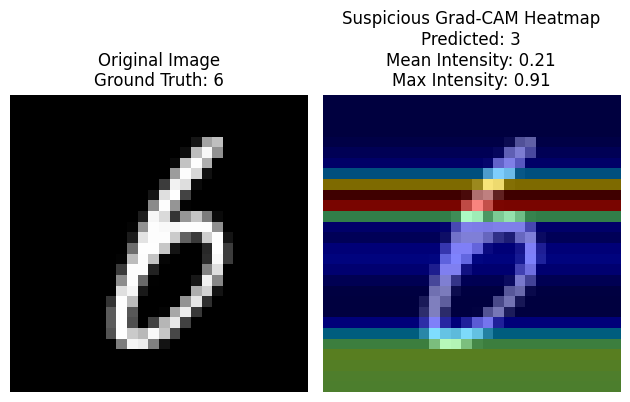

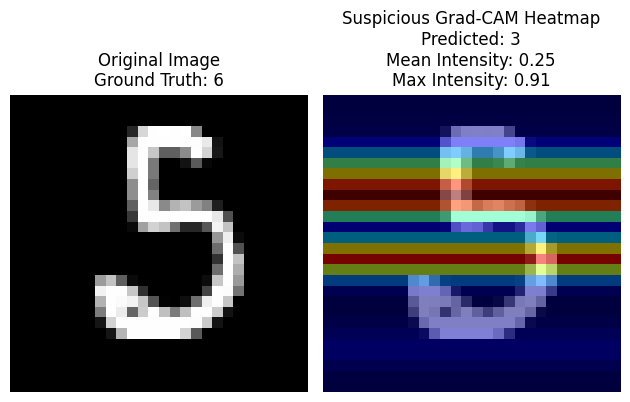

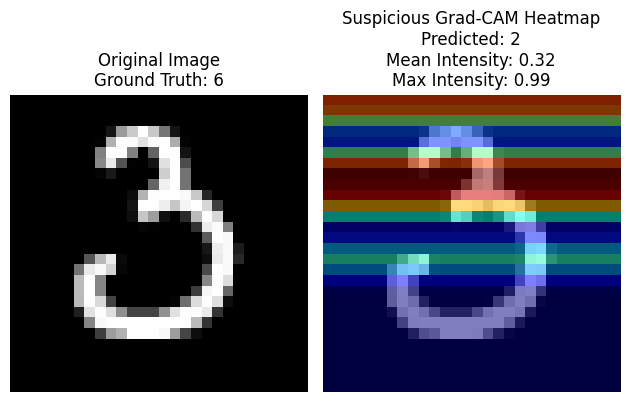

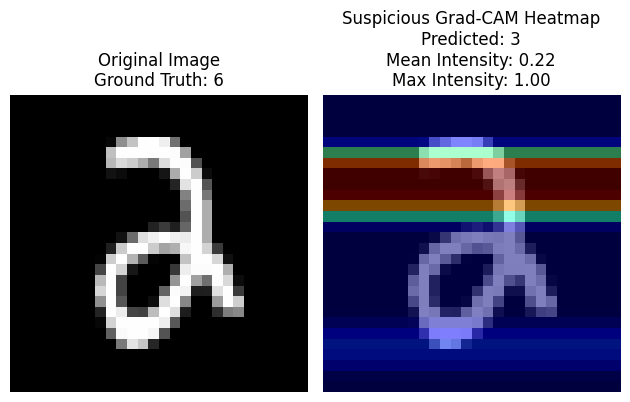

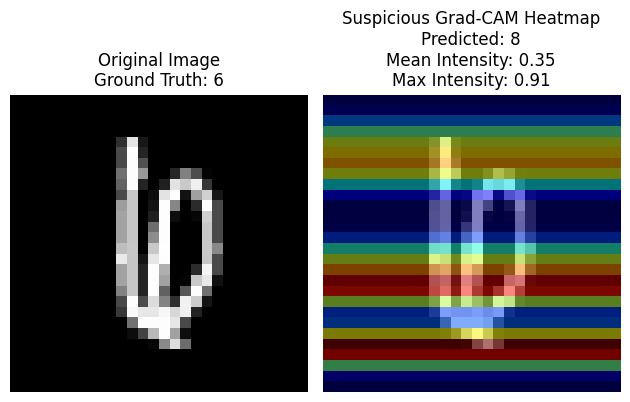

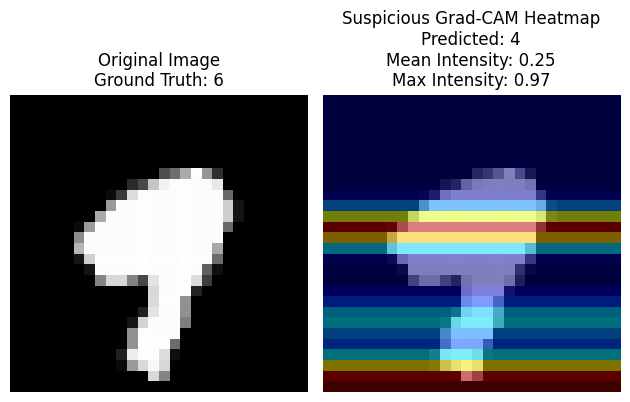

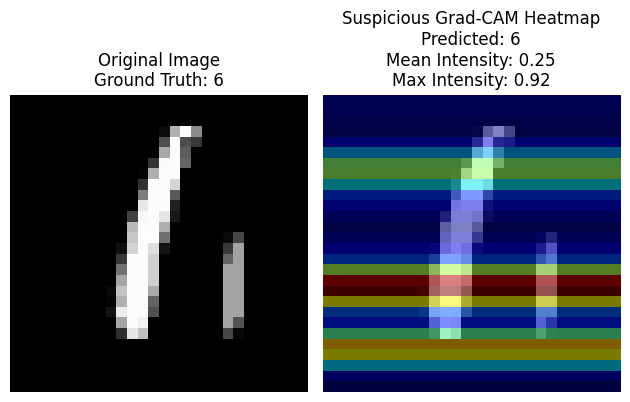

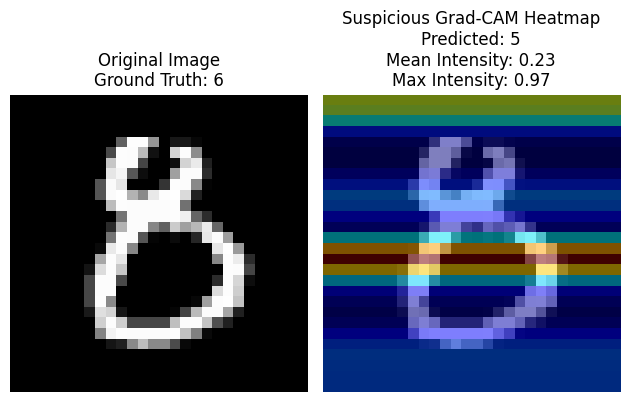

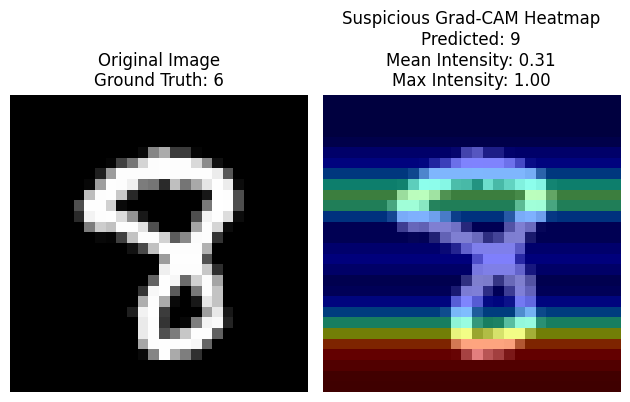

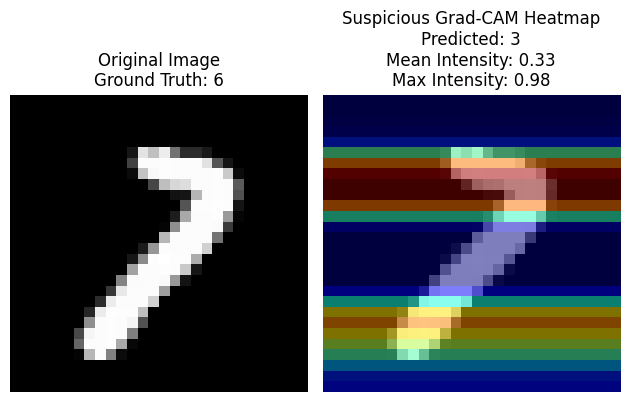

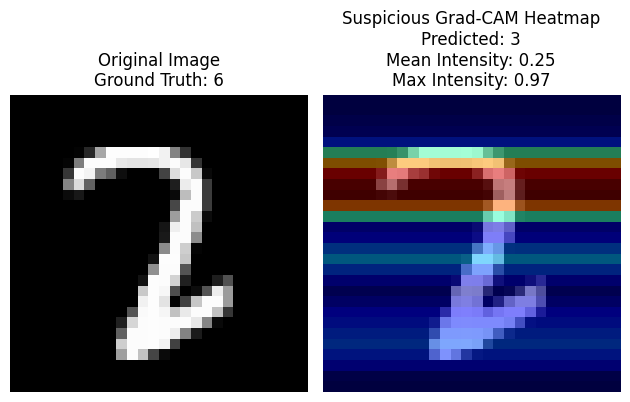

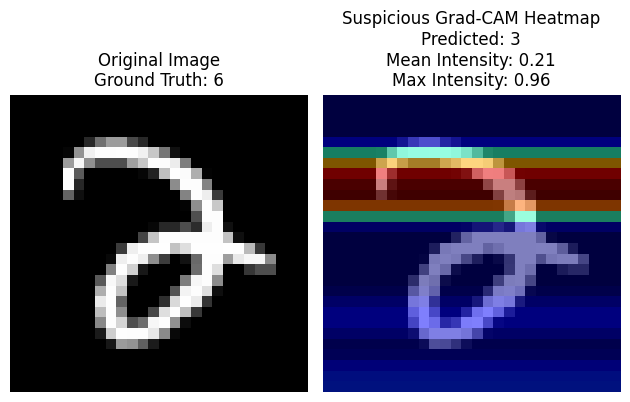

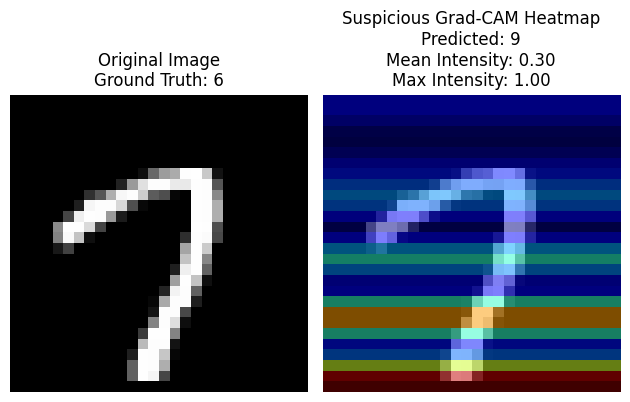

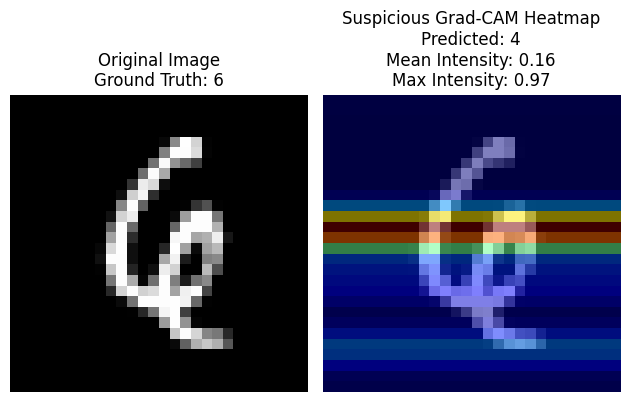

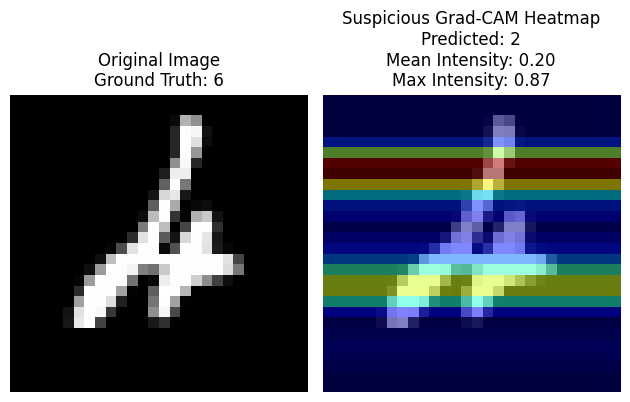

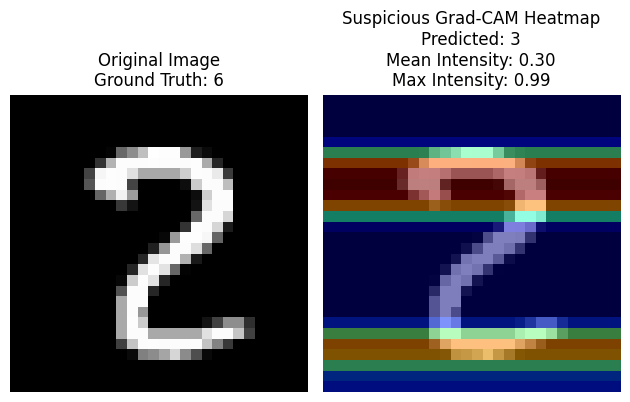

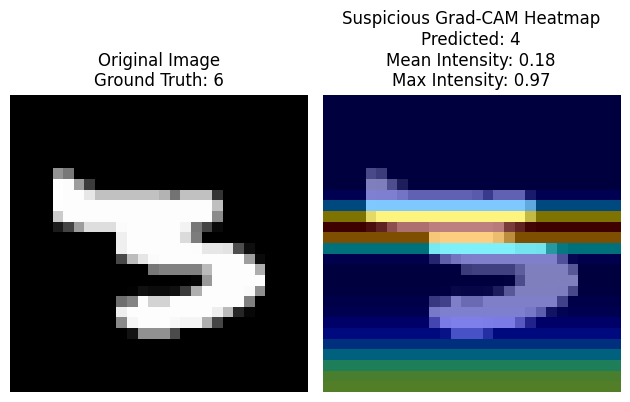

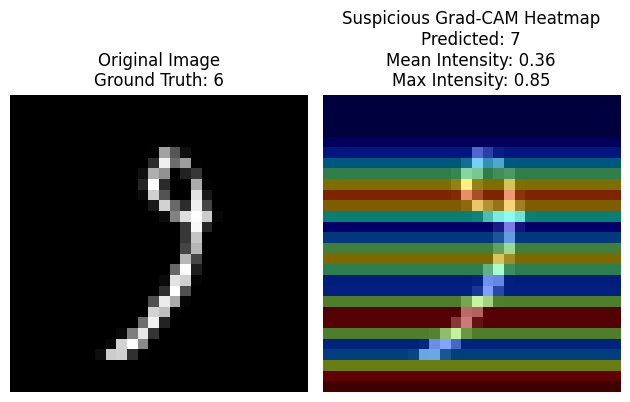

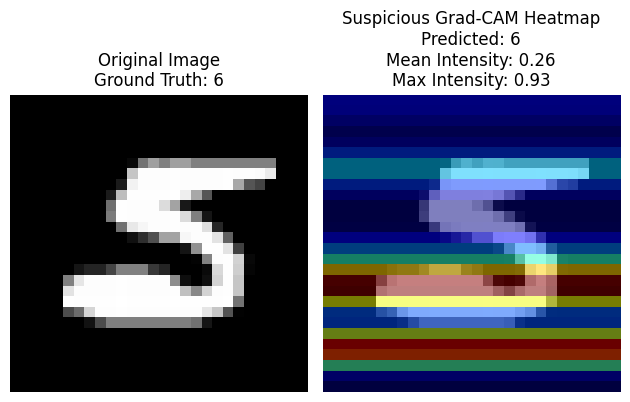

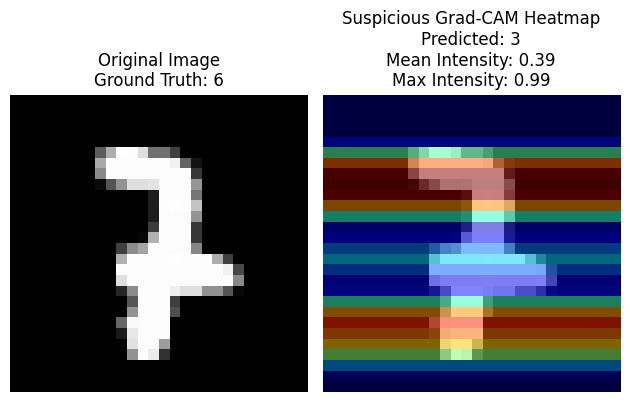

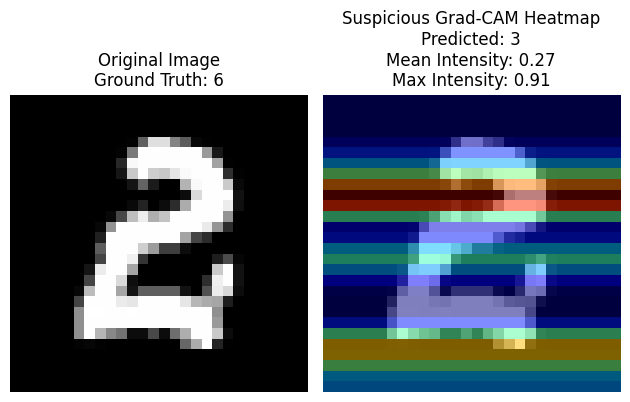

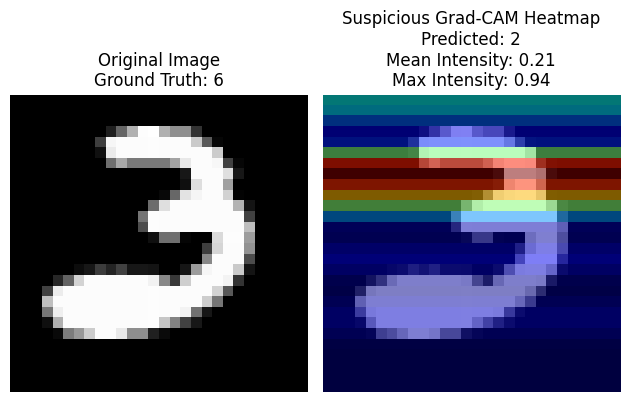

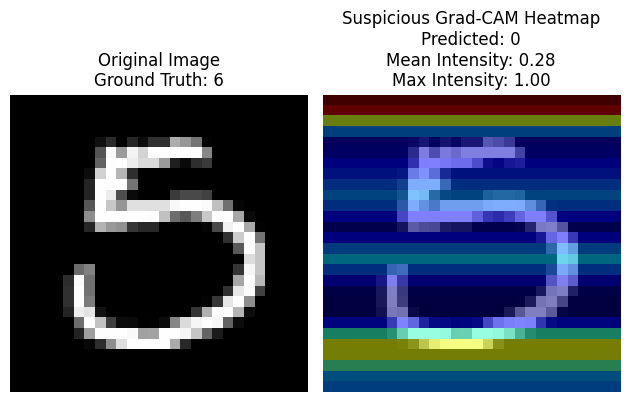

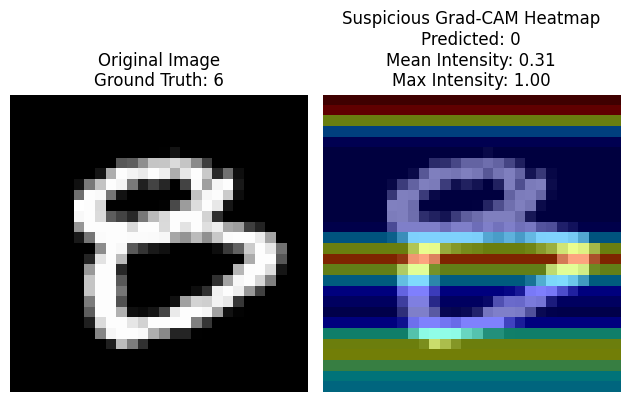

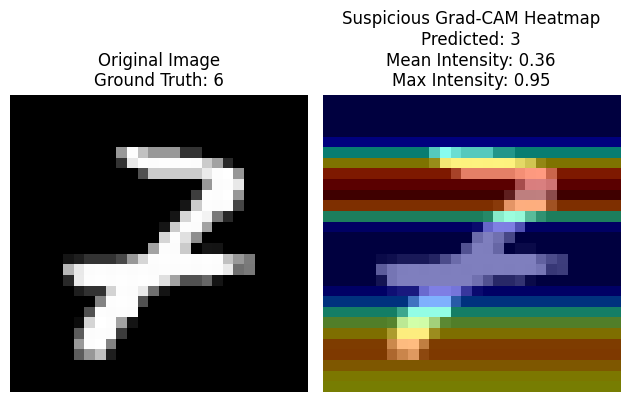

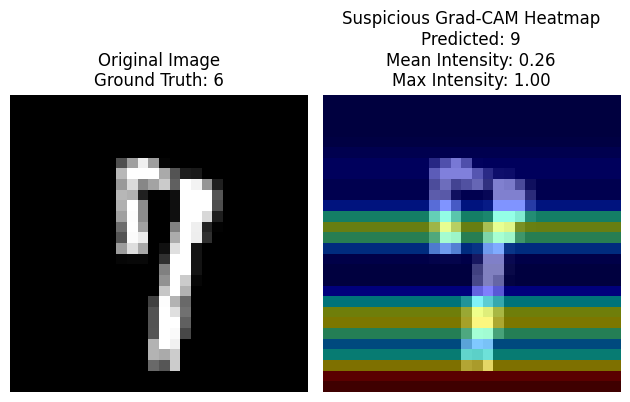

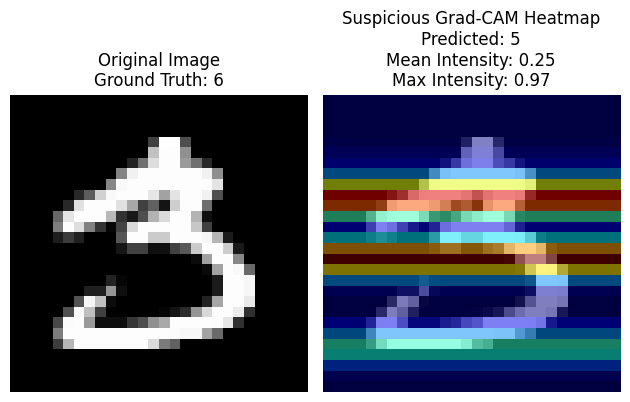

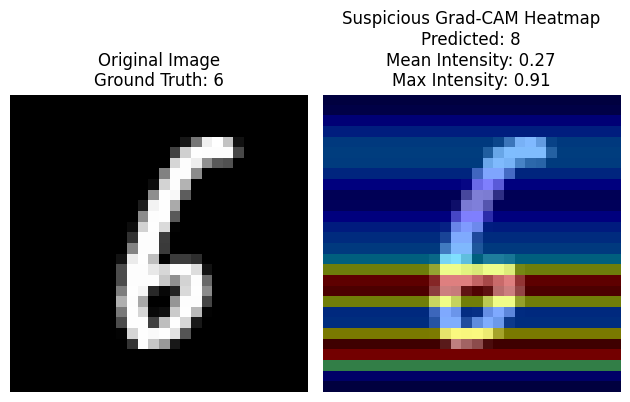

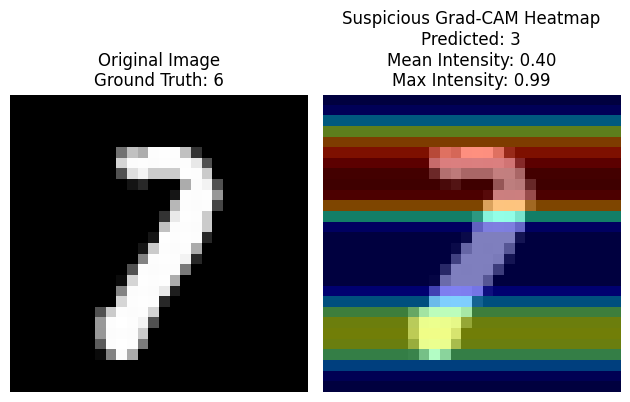

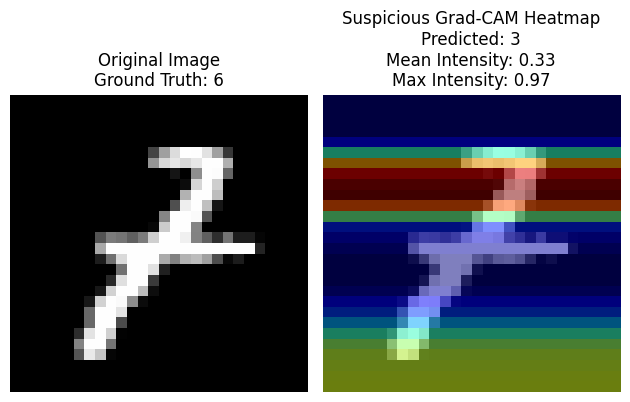

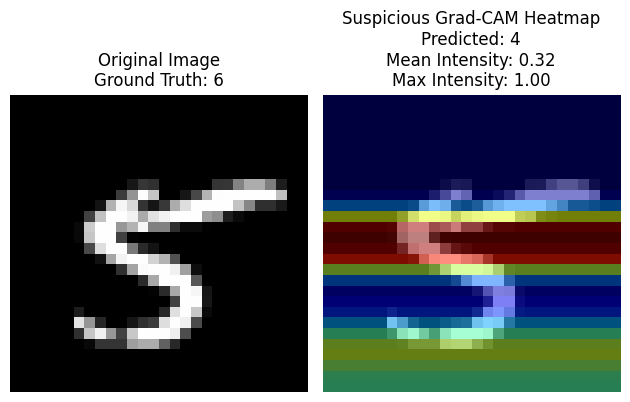

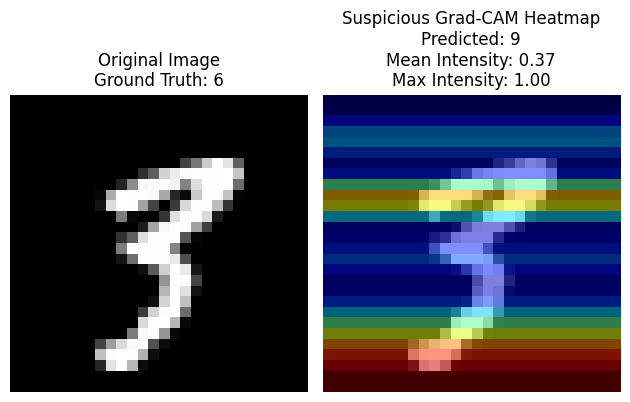

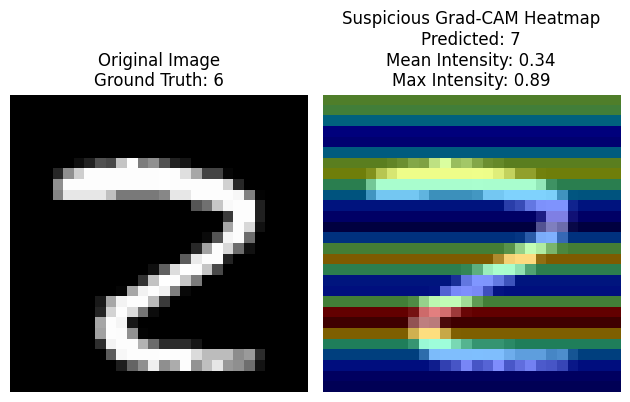

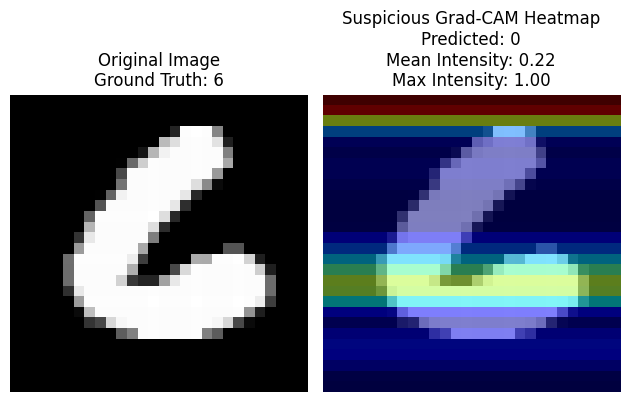

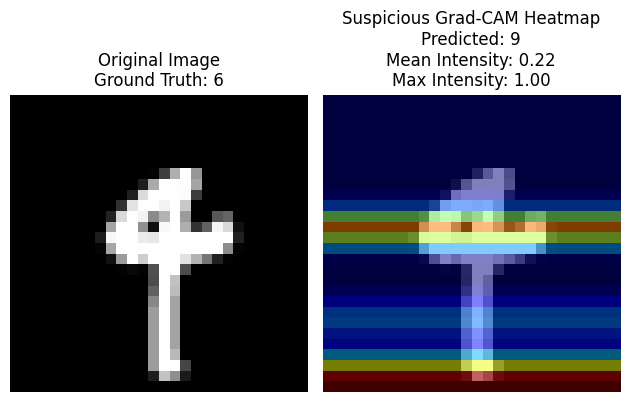

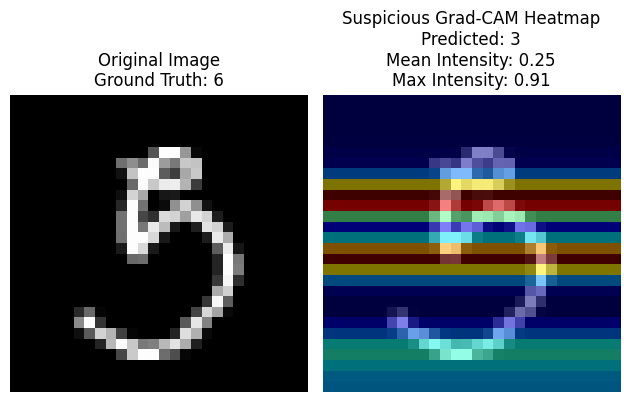

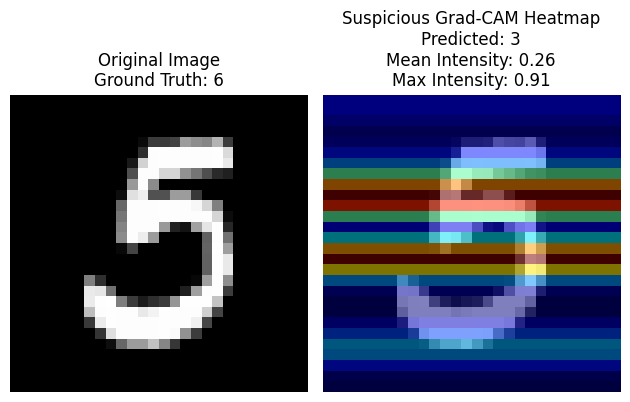

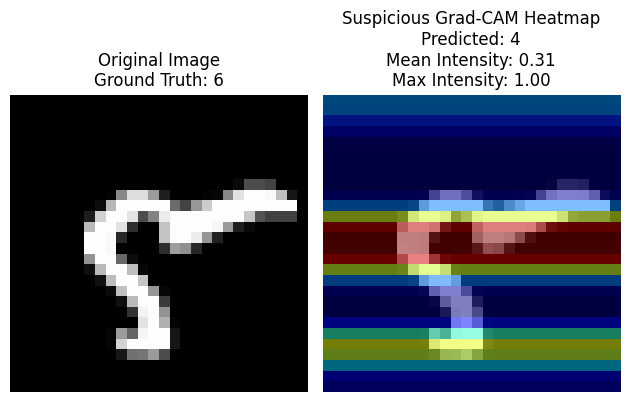

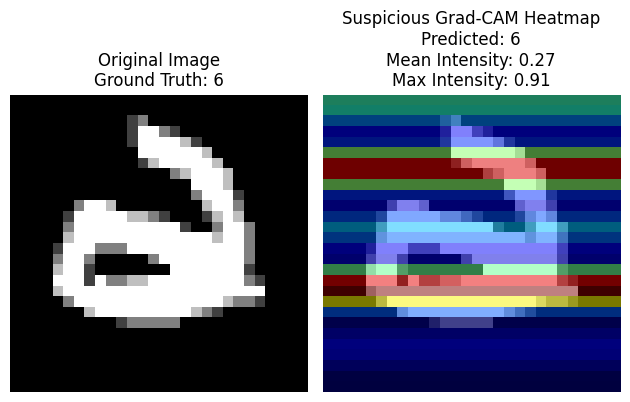

'\n\nBelow from previous attempt that has a fix number of iteration for image comparison generation.\nfor i, data in enumerate(testloader, 0):\n    inputs, labels = data\n    inputs = inputs.cpu()\n\n    cam = grad_cam.generate_cam(inputs[0].unsqueeze(0))\n\n    # Evaluate the suspiciousness based on mean and max intensity\n    mean_intensity = np.mean(cam)\n    max_intensity = np.max(cam)\n\n    # Continue if the CAM intensities are below thresholds\n    if mean_intensity < threshold_mean_intensity and max_intensity < threshold_max_intensity:\n        continue\n\n    ground_truth = labels[0].item()\n    model_output = model(inputs[0].unsqueeze(0))\n    predicted_label = torch.argmax(model_output, dim=1).item()\n\n    img = inputs.cpu().numpy()[0][0]\n    img = (img - img.min()) / (img.max() - img.min())\n\n    fig, axarr = plt.subplots(1, 2)\n\n    axarr[0].imshow(img, cmap=\'gray\')\n    axarr[0].axis("off")\n    axarr[0].set_title(f"Original Image\nGround Truth: {ground_truth}")\n\n

In [6]:
# Remember to upload the model file (.pt) into this colab session before running the code)

import torch
import cv2
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

from torch import nn
from torch.utils.data import DataLoader

import numpy as np

class MNISTNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 10)
        self.fc4 = nn.Linear(10, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        output = x
        return output

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.outputs = None

        def hook_fn(module, input_grad, output_grad):
            self.gradients = output_grad[0]

        self.target_layer.register_backward_hook(hook_fn)

    def forward(self, x):
        self.outputs = []

        def hook_fn(module, input, output):
            self.outputs.append(output)

        hook = self.target_layer.register_forward_hook(hook_fn)
        result = self.model(x)
        hook.remove()

        return result

    def generate_cam(self, input_tensor, target_category=None):
        model_output = self.forward(input_tensor)
        if target_category is None:
            target_category = np.argmax(model_output.cpu().data.numpy())

        one_hot_output = torch.zeros((1, model_output.size()[-1])).cpu()
        one_hot_output[0][target_category] = 1
        self.model.zero_grad()
        model_output.backward(gradient=one_hot_output, retain_graph=True)

        target_layer_output = self.outputs[-1].cpu().data.numpy()[0]
        gradients = self.gradients.cpu().data.numpy()[0]
        weights = np.mean(gradients, axis=0)
        cam = weights * target_layer_output

        cam = np.maximum(cam, 0)
        cam = cam / np.max(cam)
        cam = cv2.resize(cam, (32, 32))

        return cam

# Loading the model from the saved .pt file
model_path = '/content/mnist_bd.pt' #(depending on your own upload, may need to change the path accordingly)
model = MNISTNet()
model.load_state_dict(torch.load(model_path))
model.cpu()
model.eval()

# Creating data loaders for MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
testloader = DataLoader(test_dataset, batch_size=4, shuffle=True)

# Initializing Grad-CAM with the last fully connected layer
grad_cam = GradCAM(model, model.fc4)


# Below segment attempt to suss out the suspicious images
# However, this approach is not comprehensive, as i noticed that there exist images with wrong ground truths (poisoned)
# and with predicted label also giving the same wrong label.

suspicious_images = []

for i, data in enumerate(testloader, 0):
    inputs, labels = data
    inputs = inputs.cpu()

    cam = grad_cam.generate_cam(inputs[0].unsqueeze(0))
    ground_truth = labels[0].item()
    model_output = model(inputs[0].unsqueeze(0))
    predicted_label = torch.argmax(model_output, dim=1).item()

    if ground_truth != predicted_label:
        suspicious_images.append((inputs[0], cam, predicted_label))

print('Generating Comparison Imaging for Suspicious Images... \n')

threshold_mean_intensity = 0.5
threshold_max_intensity = 0.7

for img_data, cam, predicted_label in suspicious_images:
    # Evaluating the suspiciousness based on mean and max intensity

    mean_intensity = np.mean(cam)
    max_intensity = np.max(cam)

    # Note: Here, for an image to be further evaluated (i.e., visualized), its heatmap's average intensity (mean_intensity)
    # should be at least as high as threshold_mean_intensity, and its maximum intensity (max_intensity) should be
    # at least as high as threshold_max_intensity. If both these conditions aren't met, the image is skipped in the
    # visualization step. Essentially, only those images that have significant activation (beyond a certain threshold)
    # in their influential regions are considered for visualization.


    # Continuing if the CAM intensities are below thresholds
    if mean_intensity < threshold_mean_intensity and max_intensity < threshold_max_intensity:
        continue

    img = img_data.cpu().numpy()[0]  # Assuming grayscale
    img = (img - img.min()) / (img.max() - img.min())

    fig, axarr = plt.subplots(1, 2)

    axarr[0].imshow(img, cmap='gray')
    axarr[0].axis("off")
    axarr[0].set_title(f"Original Image\nGround Truth: {ground_truth}")

    axarr[1].imshow(img, cmap='gray')
    axarr[1].imshow(cv2.resize(cam, (28, 28)), cmap='jet', alpha=0.5)
    axarr[1].axis("off")
    axarr[1].set_title(f"Suspicious Grad-CAM Heatmap\nPredicted: {predicted_label}\nMean Intensity: {mean_intensity:.2f}\nMax Intensity: {max_intensity:.2f}")

    plt.tight_layout()
    plt.show()

